# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Summary
This notebook helps look at the measurements taken during the study period for the various sensors on the beacons.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np
import scipy

from datetime import datetime, timedelta

# Data Import

In [3]:
beacon_data = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0,parse_dates=True)
# show it off:
beacon_data.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-08 13:00:00,82.44,991.00,2.774400,65538.00,1.00,64.56,27.0,47.0,11.63652,28.00,...,53.796485,54.021776,6.650622,13.552581,18.829192,19.884514,1,kyj367pi,24,10
2020-06-08 13:05:00,84.85,1006.85,3.423120,68815.15,1.05,64.80,27.0,47.0,11.56110,28.00,...,52.555197,52.736052,6.513191,12.075138,16.273641,17.113340,1,kyj367pi,24,10
2020-06-08 13:10:00,79.24,1013.64,3.933120,52431.24,0.80,62.96,27.0,47.0,11.99240,28.00,...,44.265294,44.486868,5.457540,12.225936,17.449937,18.494737,1,kyj367pi,24,10
2020-06-08 13:15:00,46.72,948.96,4.452096,55052.96,0.84,61.04,27.0,46.4,11.52112,28.00,...,52.477784,52.699396,6.486844,13.275073,18.467257,19.505693,1,kyj367pi,24,10
2020-06-08 13:20:00,51.04,967.28,3.417408,20973.40,0.32,60.84,27.0,46.0,11.50412,27.12,...,47.038666,47.171580,5.841351,9.948052,13.000038,13.610435,1,kyj367pi,24,10


We also need some important information regarding shipment dates to calculate completeness. So we import the beacon-specific ```id_crossover``` file.

In [4]:
details = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='beacon',index_col=1,
                       parse_dates=['start_date','end_date','move_date'],infer_datetime_format=True)
details.head()

,REDCap,Beacon,start_date,end_date,move_date,return_date,Lat,Long,Original Address,Volume,Housemates,Roommates,Number of Rooms,NO2,original_start,original_end,original_move
Beiwe,,,,,,,,,,,,,,,,,
kyj367pi,10,1,2020-06-08 13:00:00,2020-09-03,2020-07-31,2020-09-02,30.312614,-97.732338,"2822 Rio Grande St. Apt 202 Austin, TX, 78705",1080,0,0,1.0,Yes,2020-06-15,NaT,2020-09-14
745vq78e,55,5,2020-06-09 10:21:00,2020-08-23,NaT,2020-09-08,30.288012,-97.751201,"18207 Branson Falls San Antonio, TX 78255",1188,0,0,5.0,Yes,2020-06-15,NaT,2020-08-17
itmylz3g,61,6,2020-06-17 14:08:00,2020-09-01,NaT,2020-09-01,29.855371,-95.741200,"5403 Dunsmore Harbor Ln, Katy, TX 77449",1188,0,0,5.0,Yes,2020-06-15,2020-09-11,2020-07-03
zdpffrox,0,7,2020-06-01 00:00:00,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,"2211 Lawnmont Avenue apt 314 Austin, TX 78756",1365,1,1,NaN,Yes,2020-06-06,2020-09-03,2020-07-31
xlw5ntd5,43,10,2020-06-08 13:19:00,2020-09-11,2020-08-10,2020-09-22,30.351693,-97.614524,"6704 bramber ln, austin, tx 78754",1188,0,0,NaN,Yes,2020-06-08,NaT,2020-07-01


# Base Analysis
Here we look at the raw, unaltered data in order to understand:
- which participants submitted data?
- what data are available? (see 4.1.1 notebook to see when participants actually measured data)
- how much data were collected?
- what are typical measurements and what does this say?
- are there any misbehaving sensors?

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import LogNorm

## Which participants submitted data?
Here we look at what beacons are represented in each of the three types of beacon datasets:
1. All available beacon data
2. Beacon data filtered by Fitbit-recorded sleep events when home (cross-references with GPS)
3. Beacon data from 2) further filtered by completed EMAs the next morning.

### All Available beacon data

In [6]:
print(f'Number of beacons represented:',len(beacon_data['Beacon'].unique()))
print(f'\tBeacons:',beacon_data['Beacon'].unique())
print(f'\tBeiwe:', beacon_data['Beiwe'].unique())

Number of beacons represented: 25
	Beacons: [ 1  5  6  7 10 11 15 16 17 19 21 22 24 25 26 28 29 30 32 34 36 38 40 44
 46]
	Beiwe: ['kyj367pi' '745vq78e' 'itmylz3g' 'zdpffrox' 'xlw5ntd5' 'i31pt4b4'
 '9jtzsuu8' 'e73a1pd5' '9xmhtq74' 'qh34m4r9' 'lkkjddam' 'xxvnhauv'
 'xdbdrk6e' 'vr9j5rry' 'awa8uces' 'hxj6brwj' 'tmexej5v' 'idbkjh8u'
 '2xtqkfz1' 'rnse61g4' 'tlmlq19s' 'olaxadz5' 'i4w8dx6l' '4i7679py'
 'nvtfpaor']


### When participants are home and asleep

In [7]:
df = pd.read_csv('../data/processed/bpeace2-beacon-fb_and_gps_restricted.csv',
                             index_col=0)
print(f'Number of beacons represented:',len(df['Beacon'].unique()))
print(f'\tBeacons:',df['Beacon'].unique())
print(f'\tBeiwe:', df['Beiwe'].unique())

Number of beacons represented: 17
	Beacons: [21  6  7 19 29 10  1  5 25 34 44 15 24 11 28 36 17]
	Beiwe: ['lkkjddam' 'itmylz3g' 'zdpffrox' 'qh34m4r9' 'tmexej5v' 'xlw5ntd5'
 'kyj367pi' '745vq78e' 'vr9j5rry' 'rnse61g4' '4i7679py' '9jtzsuu8'
 'xdbdrk6e' 'i31pt4b4' 'hxj6brwj' 'tlmlq19s' '9xmhtq74']


### When participants are home, asleep, and filled out survey

In [8]:
df = pd.read_csv('../data/processed/bpeace2-beacon-fb_ema_and_gps_restricted.csv',
                             index_col=0)
print(f'Number of beacons represented:',len(df['Beacon'].unique()))
print(f'\tBeacons:',df['Beacon'].unique())
print(f'\tBeiwe:', df['Beiwe'].unique())

Number of beacons represented: 17
	Beacons: [21  6  7 19 29 10  1  5 25 34 44 15 24 11 28 36 17]
	Beiwe: ['lkkjddam' 'itmylz3g' 'zdpffrox' 'qh34m4r9' 'tmexej5v' 'xlw5ntd5'
 'kyj367pi' '745vq78e' 'vr9j5rry' 'rnse61g4' '4i7679py' '9jtzsuu8'
 'xdbdrk6e' 'i31pt4b4' 'hxj6brwj' 'tlmlq19s' '9xmhtq74']


## What data are available?
Here we look at some basic visualizations to get a sense of the data collected

### Heatmaps by Sensor
These heatmaps show the values measured by a specific sensor on all of the beacons, but are more useful for determining when data are available.

Working for PM_C_2p5
	Data collected
	Plotting


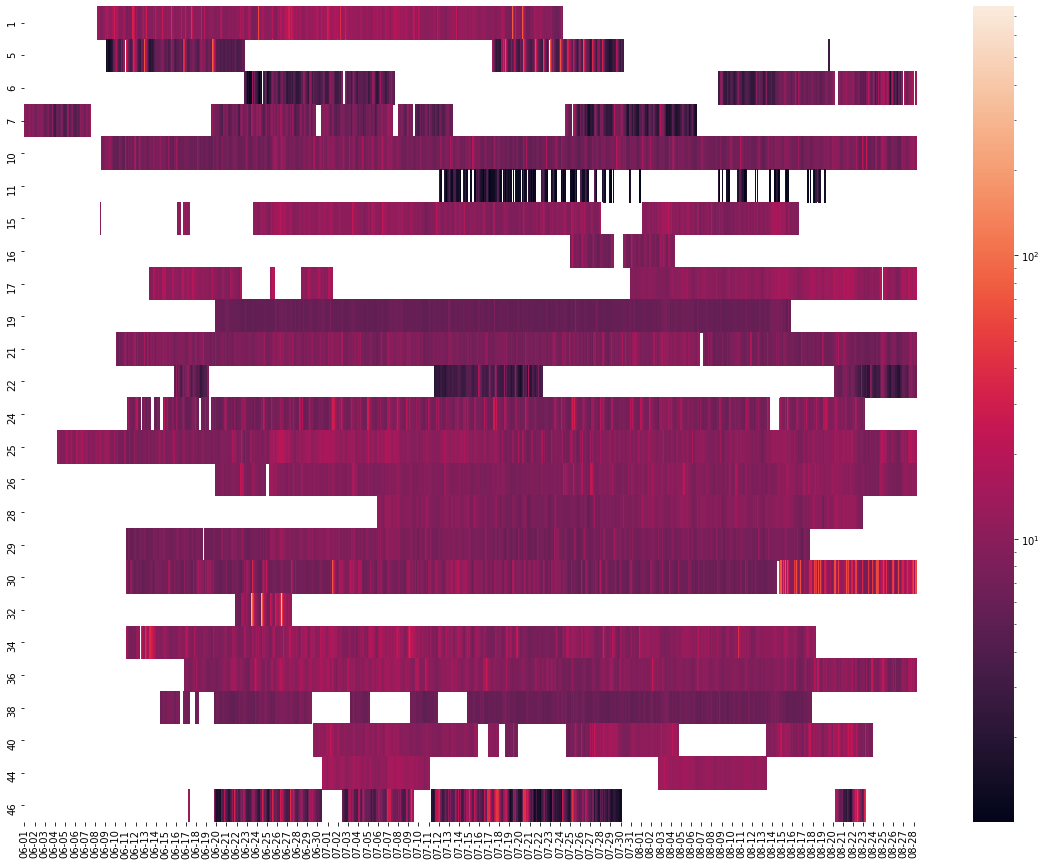

Working for CO2
	Data collected
	Plotting


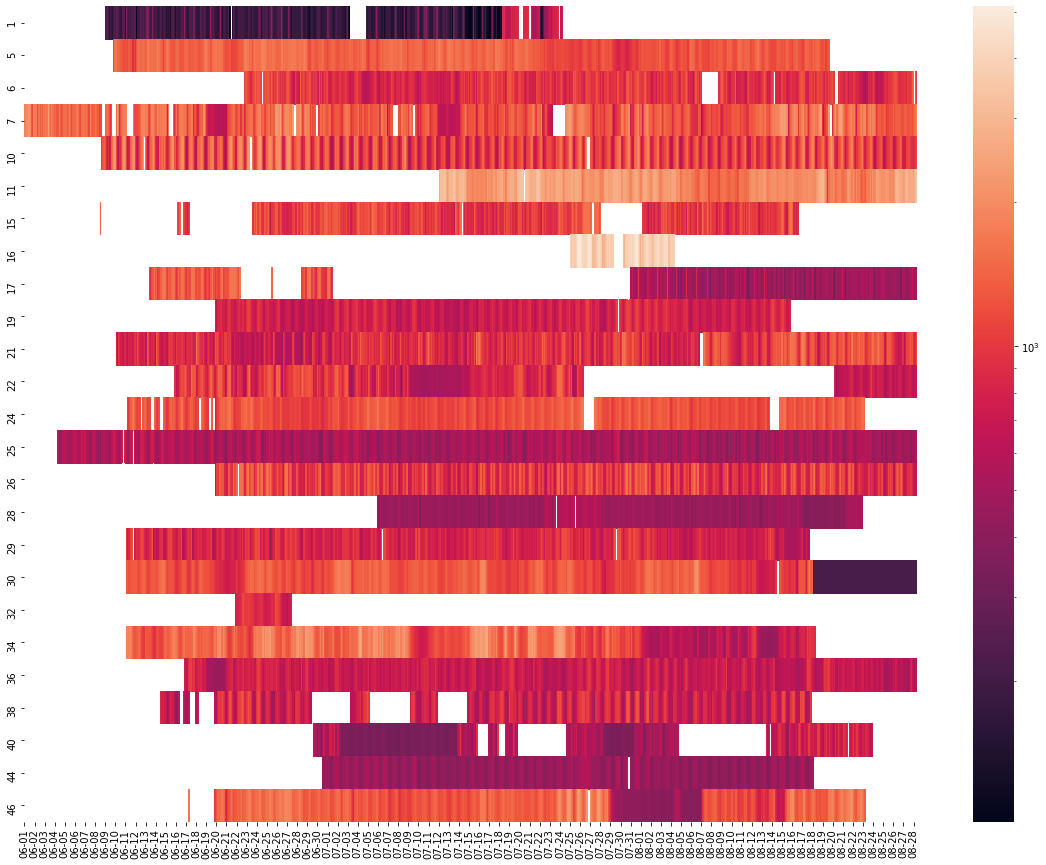

Working for CO
	Data collected
	Plotting


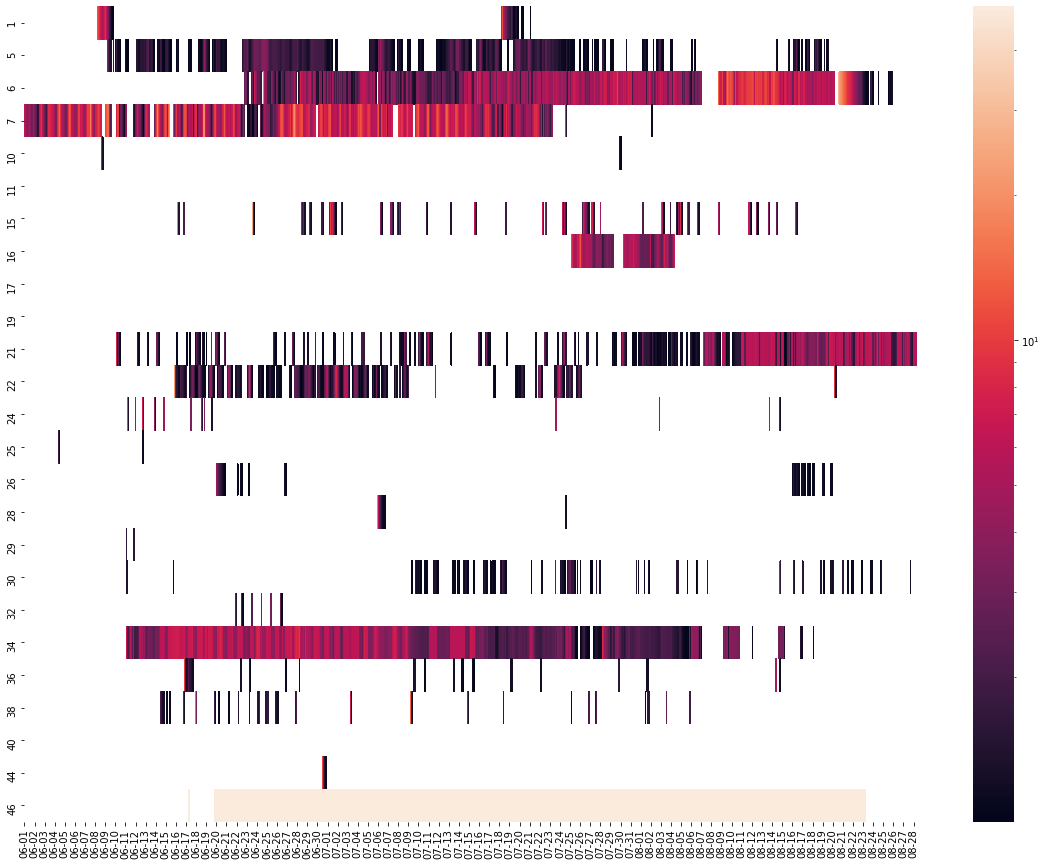

Working for NO2
	Data collected
	Plotting


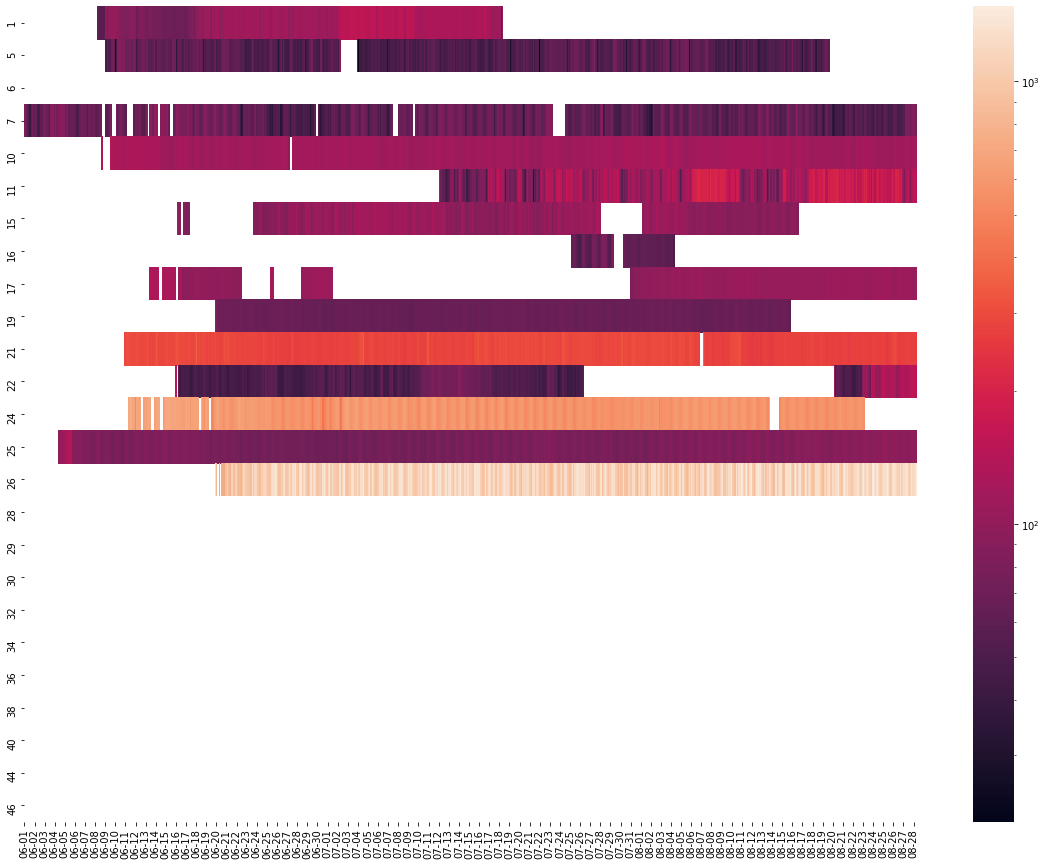

Working for T_NO2
	Data collected
	Plotting


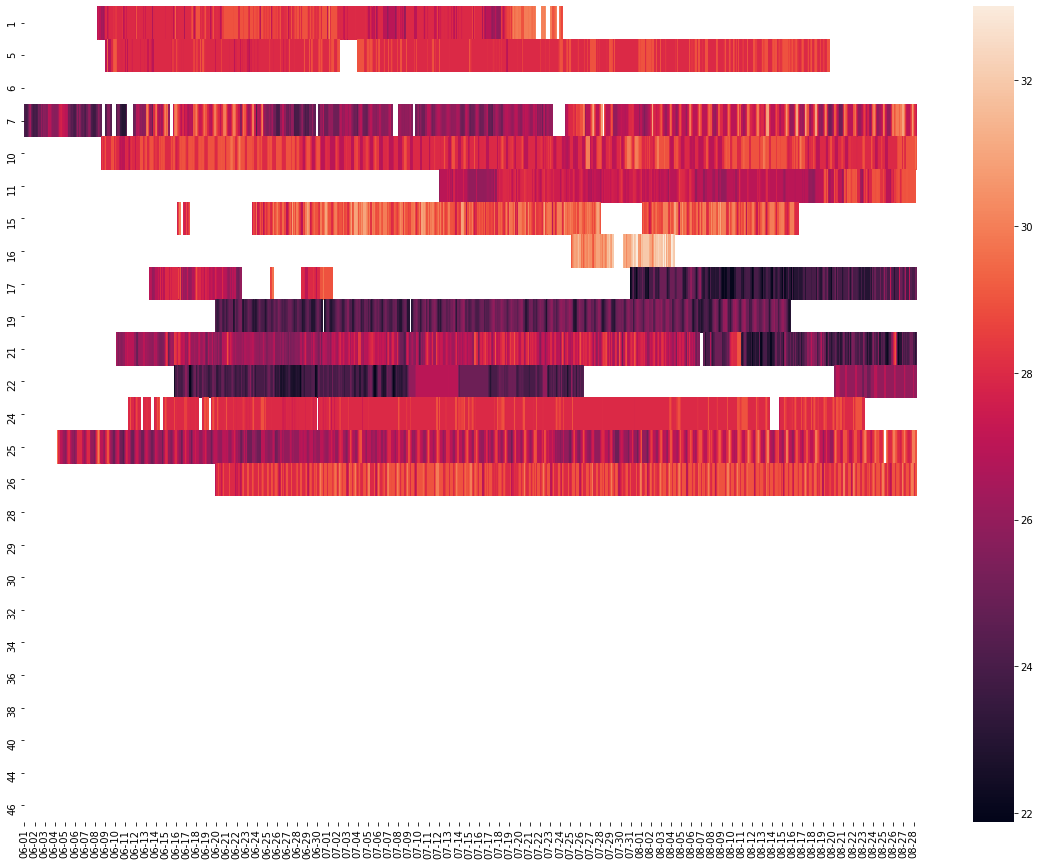

Working for Lux
	Data collected
	Plotting


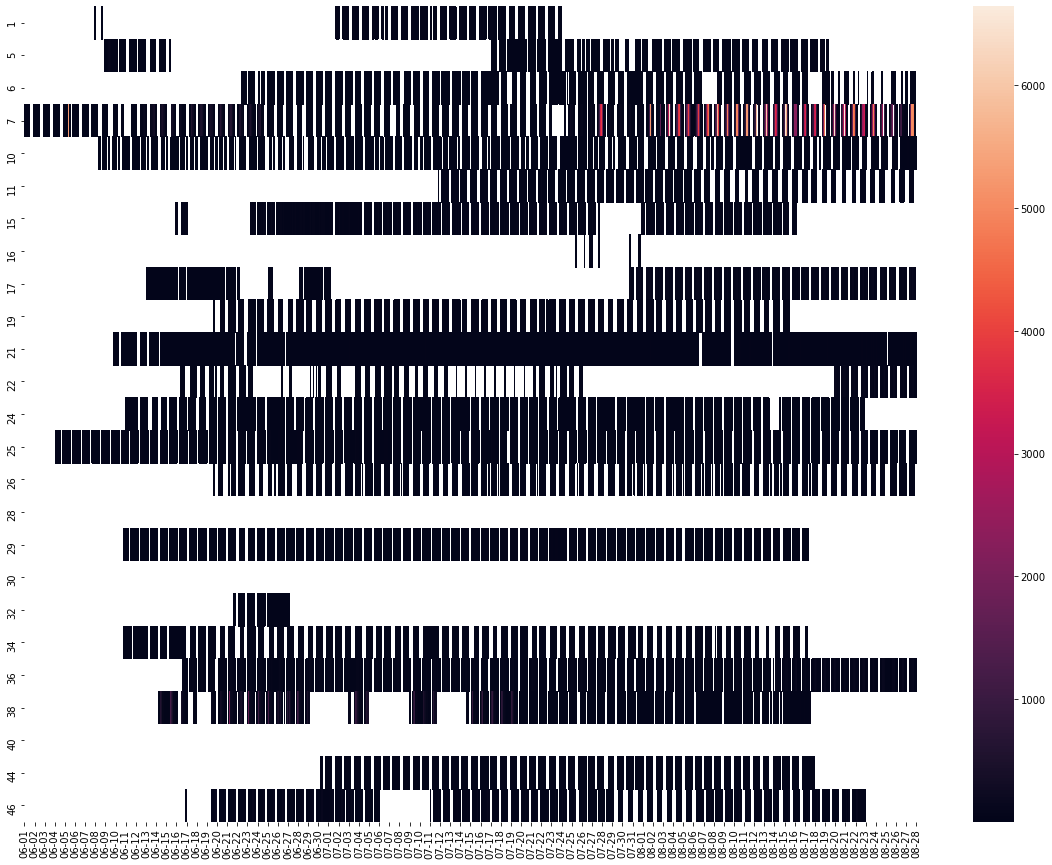

In [9]:
var_list = ['PM_C_2p5','CO2','CO','NO2','T_NO2','Lux']
limit_list = [[1,75],[1,2000],[1,20],[1,100],[1,50],[0,600000]]
for variable, limits in zip(var_list, limit_list):
    print(f'Working for {variable}')
    heatmap_df = pd.DataFrame()
    for beacon in beacon_data['Beacon'].unique():
        data_by_beacon = beacon_data[beacon_data['Beacon'] == beacon]
        data_by_beacon = data_by_beacon[data_by_beacon[variable] > 1]
        data_by_beacon = data_by_beacon.resample('1h').mean()
        sdate = datetime(2020,6,1)
        edate = datetime(2020,9,1)
        data_by_beacon = data_by_beacon[sdate:edate]
        heatmap_df = pd.concat([heatmap_df,data_by_beacon[variable]],axis=1)
        heatmap_df.rename(columns={variable:beacon}, inplace=True)

    print(f'\tData collected')
    fig, ax = plt.subplots(figsize=(20,15))
    df_to_plot = heatmap_df.T
    print(f'\tPlotting')
    if variable[0] in ['T','L']:
        sns.heatmap(df_to_plot,vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot))
    else:
        sns.heatmap(df_to_plot,norm=LogNorm(vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot)))
        
    x_labels = []
    for d in pd.date_range(sdate,edate-timedelta(days=1),freq='d'):
        x_labels.append(d.strftime('%m-%d'))
        
    ax.set_xticklabels(x_labels)
    
    plt.show()
    plt.close()

### Time Series Sensor Operation
Now we show individual beacons as a simplified time series to see that the sensors were operating.

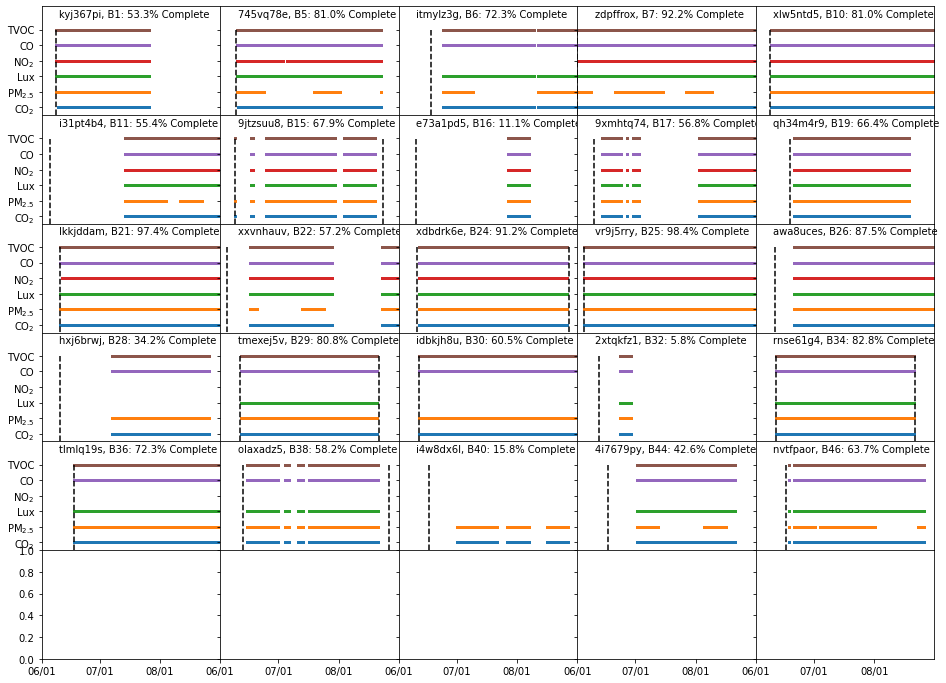

In [10]:
fig, axes = plt.subplots(6,5,figsize=(16,12),sharex=True,sharey='row')
rows = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5]
cols = [0,1,2,3,4]*6
sensors = ['CO2','PM_C_2p5','Lux','NO2','CO','TVOC']
sensor_datapoints_dict = {'CO2':0,'PM_C_2p5':0,'Lux':0,'NO2':0,'CO':0,'TVOC':0}
for beiwe, r, c in zip(beacon_data['Beiwe'].unique(),rows,cols):
    # restricting to participant
    beacon_by_beiwe = beacon_data[beacon_data['Beiwe'] == beiwe]
    beacon_by_beiwe = beacon_by_beiwe[details.loc[beiwe,'start_date']:details.loc[beiwe,'end_date']]
    beacon = beacon_by_beiwe['Beacon'][0]
    limits = [-50,0,-10,-1000,-1000,-50]
    # Getting overall percentage of data completion
    total_datapoints = (details.loc[beiwe,'return_date'] - details.loc[beiwe,'start_date'] + timedelta(days=1)).days
    # x24 x60 to get into minutes, /5 for interverals, x6 for number of sensors
    total_datapoints = total_datapoints * 24 * 60 / 5 * len(sensors)
    available_datapoints = 0
    for sensor in sensors:
        available_datapoints += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
        sensor_datapoints_dict[sensor] += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
    total_percent = round(available_datapoints / total_datapoints * 100,1)
    
    i = 1
    ax = axes[r,c]
    for sensor, limit in zip(sensors,limits):
        beacon_by_beiwe[f'{sensor}_op'] = np.select([pd.to_numeric(beacon_by_beiwe[sensor],errors='coerce') > limit],[i])
        ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe[f'{sensor}_op'],s=5,marker='s')
        i += 1
    # plotting start and stop dates
    ax.plot([details.loc[beiwe,'start_date'],details.loc[beiwe,'start_date']],[0,6],color='black',linestyle='dashed')
    ax.plot([details.loc[beiwe,'return_date']+timedelta(days=1),details.loc[beiwe,'return_date']+timedelta(days=1)],[0,6],color='black',linestyle='dashed')
    ax.text(datetime(2020,6,10),7,f'{beiwe}, B{beacon}: {total_percent}% Complete',va='center',ha='left')
    ax.set_ylim([0.5,7.5])
    ax.set_xlim([datetime(2020,6,1),datetime(2020,9,1)])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[6,7,8]))
    ax.set_yticks(np.arange(1,7,1))
    ax.set_yticklabels(['CO$_2$','PM$_{2.5}$','Lux','NO$_2$','CO','TVOC'])
    
plt.subplots_adjust(hspace=0,wspace=0)
#plt.savefig('../reports/utx000_initial_update/figures/time-beacon-sensor-operation-comprehensive.pdf')
plt.show()
plt.close()

### Heatmap per beacon
Now we can look at individual beacons and see how well they recorded during a specific time period. 

In [11]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def create_cmap(colors,nodes):
    cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
    return cmap

<div class="alert alert-block alert-success">
    We are looking for a good summary of a week's worth of data. Looks:
    <ul>
        <li>week of July 6 is a good place to start</li>
        <li>Beacon 19</li>
    </ul>
    </div>

1:


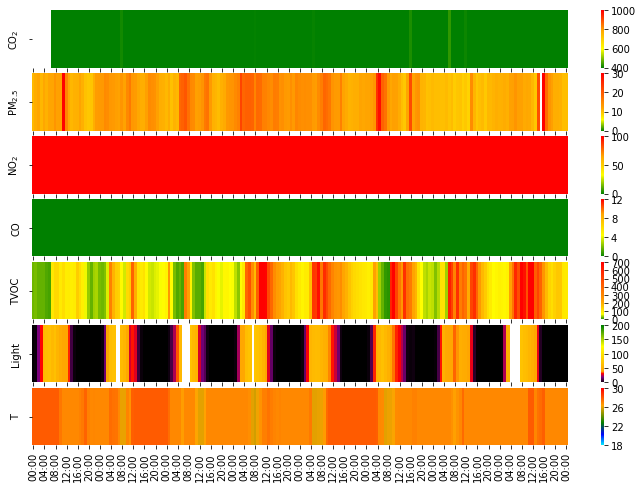

5:


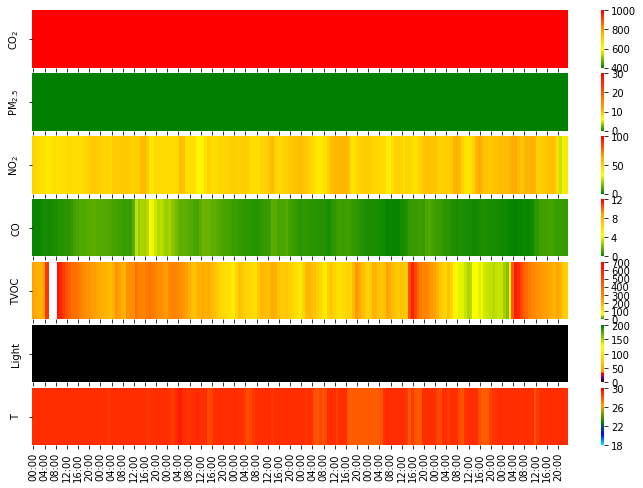

6:


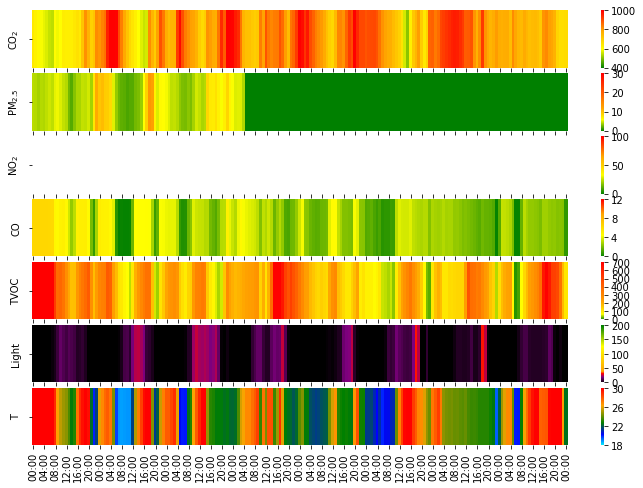

7:


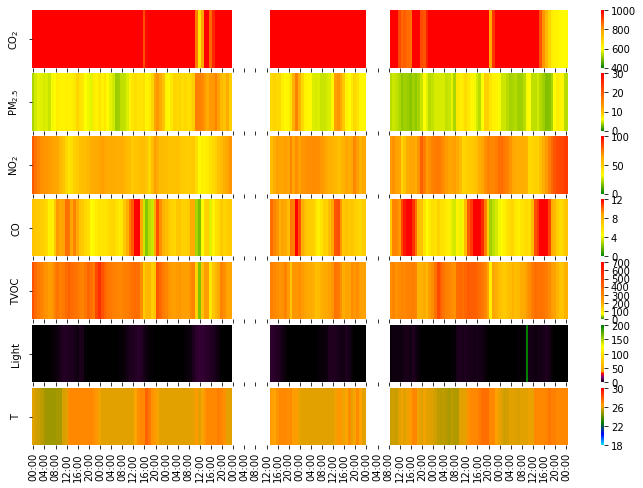

10:


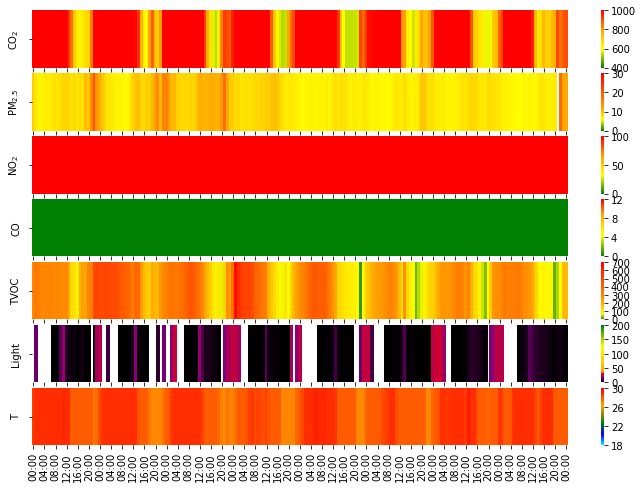

11:


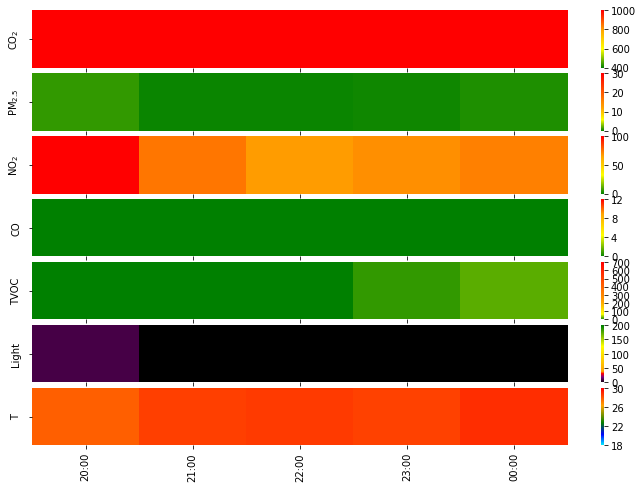

15:


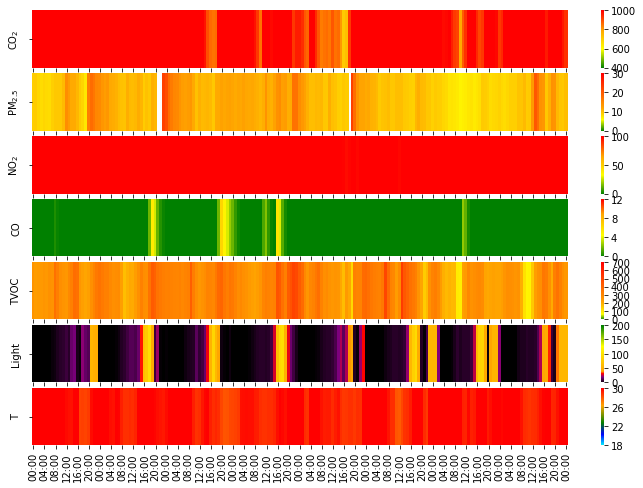

16:


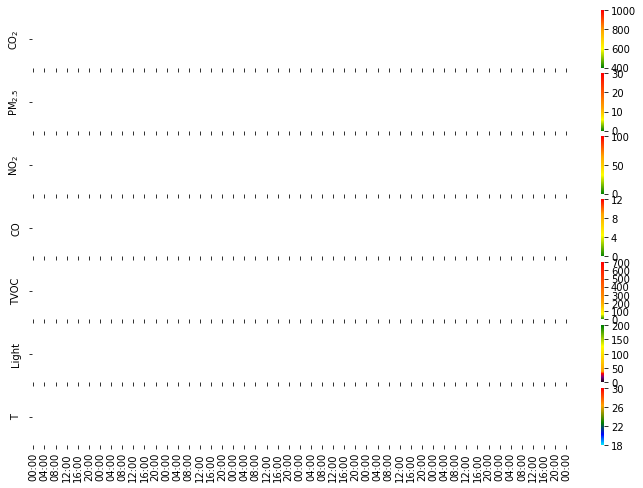

17:


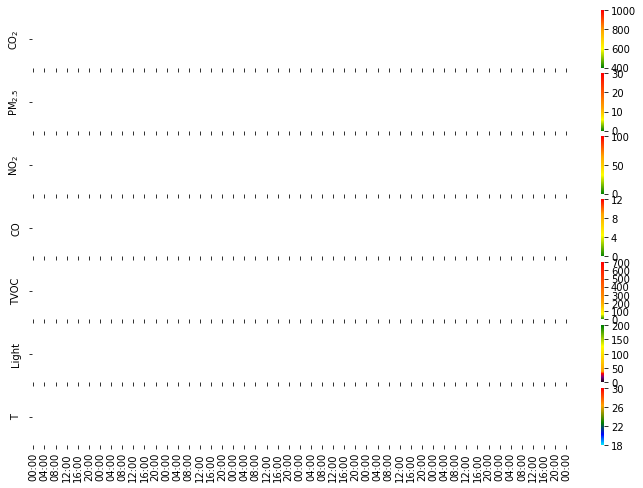

19:


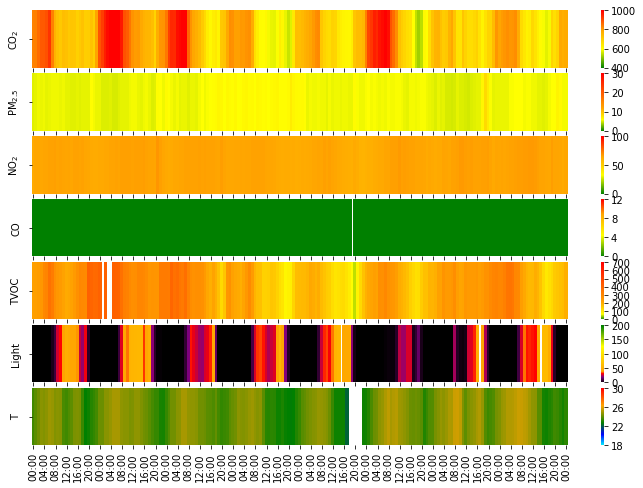

21:


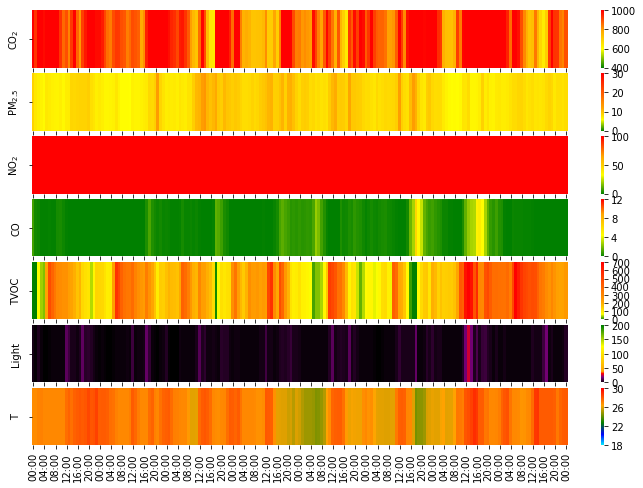

22:


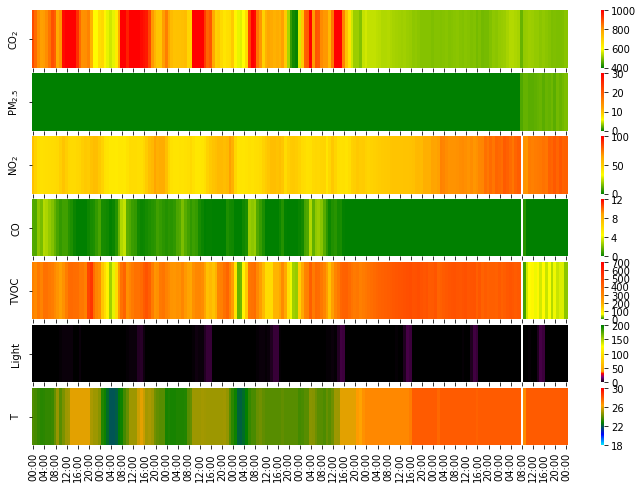

24:


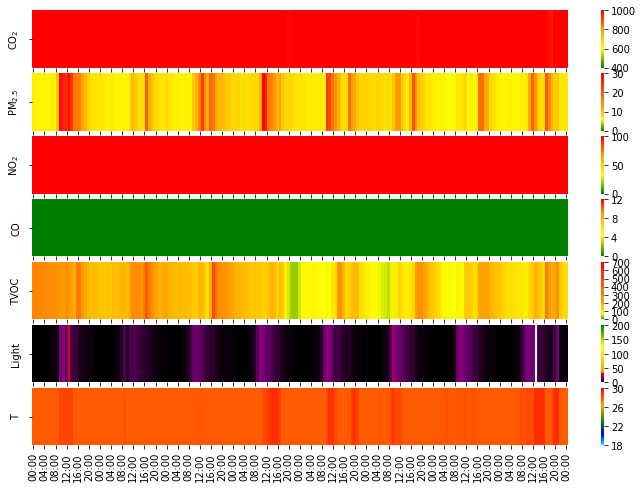

25:


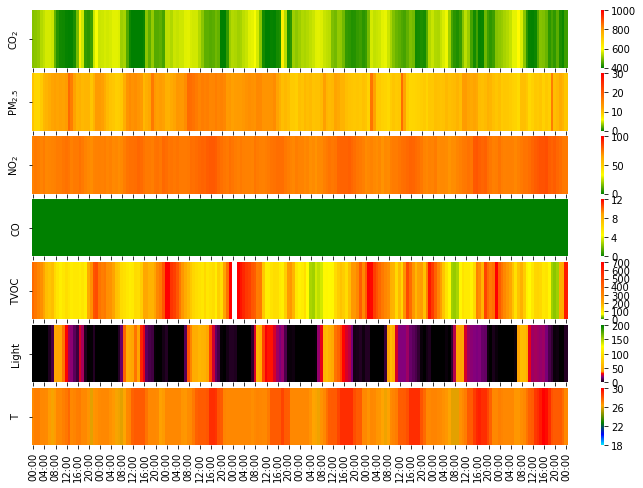

26:


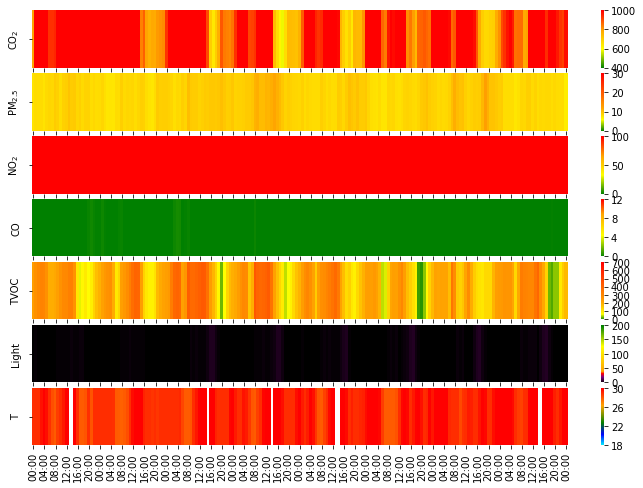

28:


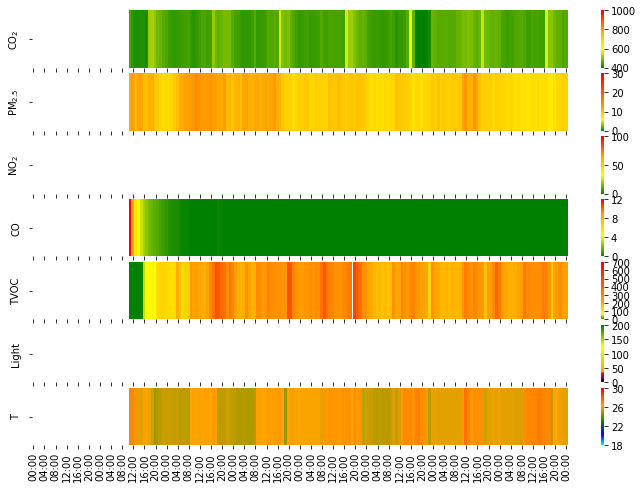

29:


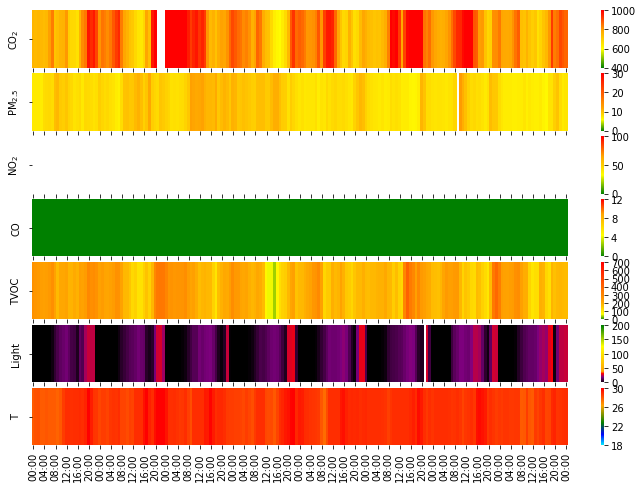

30:


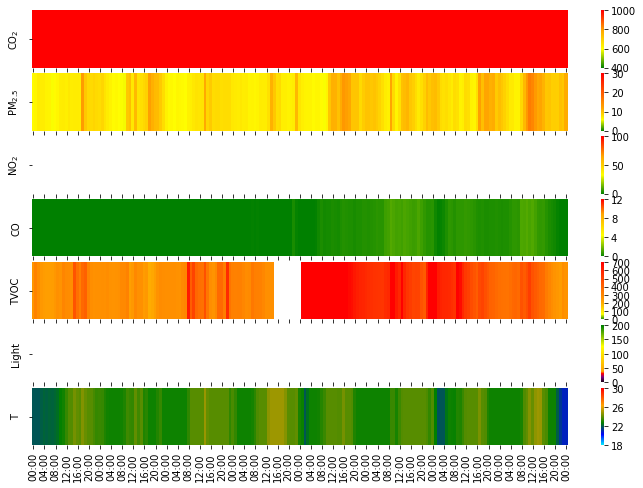

34:


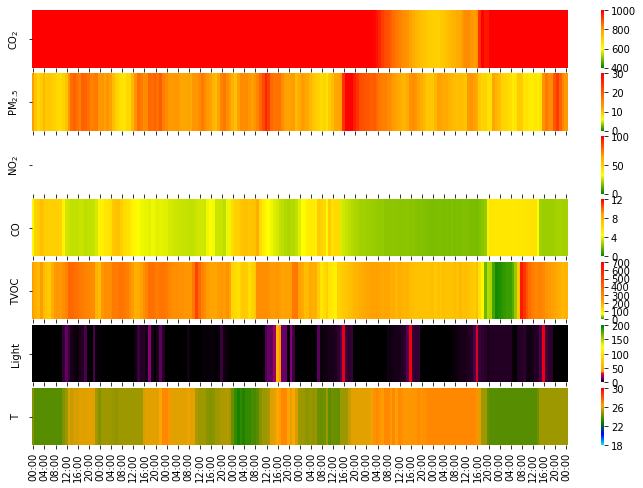

36:


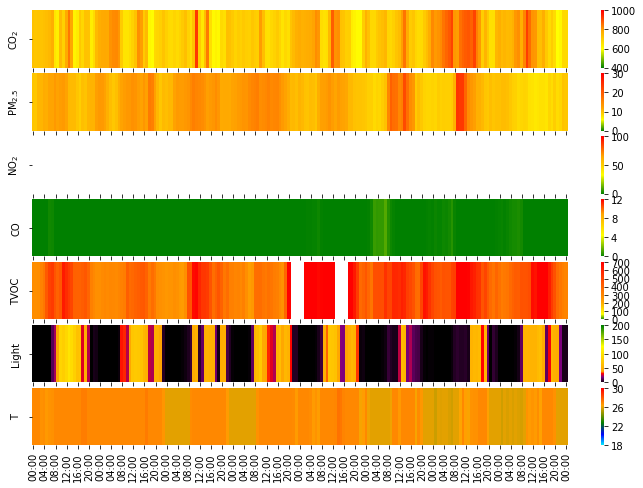

38:


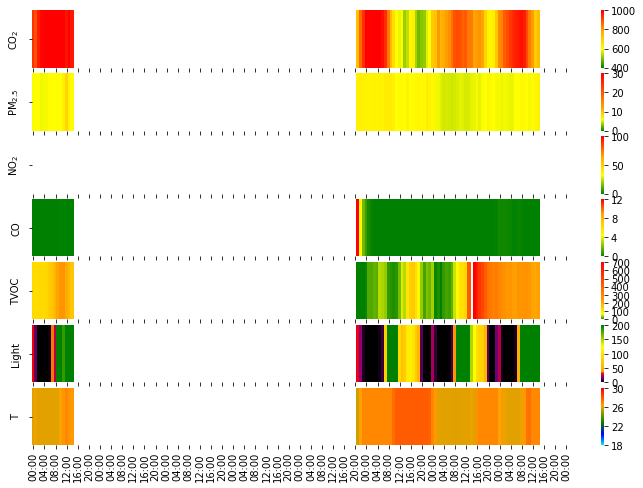

40:


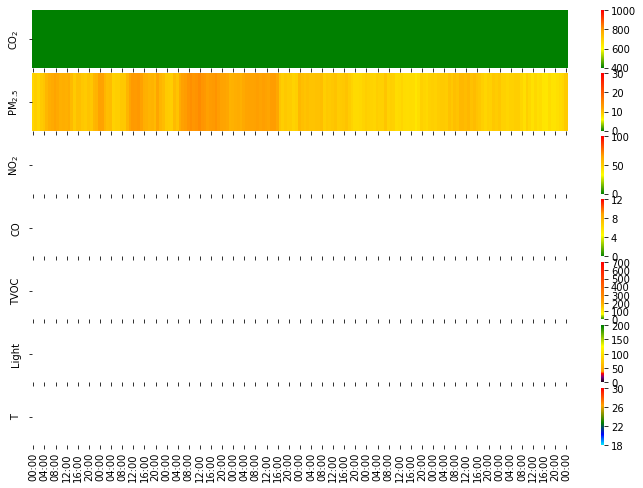

44:


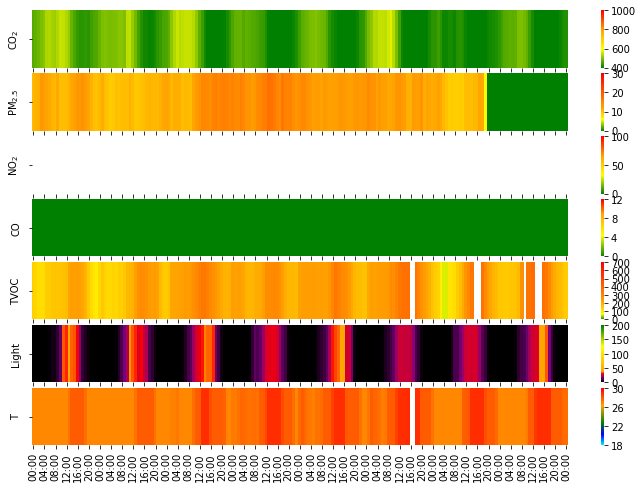

46:


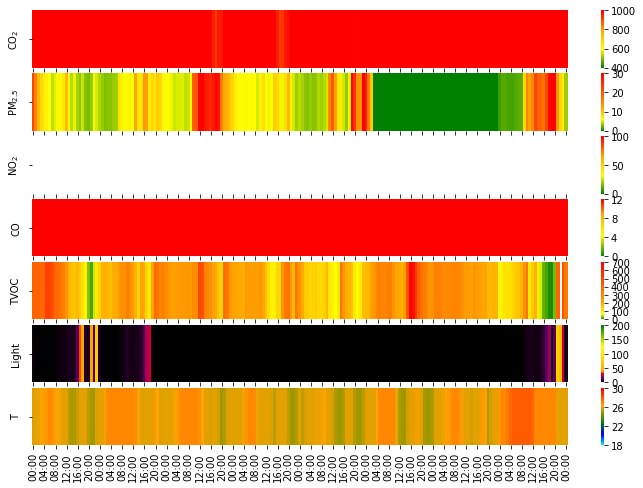

In [12]:
for bb in beacon_data['Beacon'].unique():
    beacon_bb = beacon_data[beacon_data['Beacon'] == bb][datetime(2020,7,6):datetime(2020,7,14)]
    if len(beacon_bb['NO2']) > 10:
        print(f'{bb}:')
        beacon_bb = beacon_bb.resample('60T').mean()
        beacon_bb_pollutants = beacon_bb[['CO2','PM_C_2p5','NO2','CO','TVOC','Lux','T_CO']]
        fig, axes = plt.subplots(7,1,figsize=(12,8),sharex=True)
        ylabels = ['CO$_2$',
                   'PM$_{2.5}$',
                   'NO$_2$',
                   'CO',
                   'TVOC',
                   'Light',
                   'T']
        cbar_ticks = [np.arange(400,1200,200),
                      np.arange(0,40,10),
                      np.arange(0,120,50),
                      np.arange(0,15,4),
                      np.arange(0,800,100),
                      np.arange(0,250,50),
                      np.arange(18,32,4)]
        cmaps = [create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.33, 0.66, 1]),
                 create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.2, 0.4, 1]),
                 create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.33, 0.66, 1]),
                 create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.375, 0.75, 1]),
                 create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.1, 0.31, 1]),
                 create_cmap(["black","purple","red","orange","yellow","green"],[0.0, 0.1, 0.16, 0.2, 0.64, 1]),
                 create_cmap(["cyan","blue","green","orange","red"],[0.0, 0.2, 0.4, 0.7, 1])]
        for ax, var, low, high, ylabel, ticks, cmap in zip(axes,beacon_bb_pollutants.columns,[400,0,0,0,0,0,18],[1000,30,100,12,700,200,30],ylabels,cbar_ticks,cmaps):
            sns.heatmap(beacon_bb_pollutants[[var]].T,vmin=low,vmax=high,ax=ax,cbar_kws={'ticks':ticks},cmap=cmap)
            ax.set_ylabel(ylabel)
            ax.set_yticklabels([''])
            ax.set_xlabel('')

        xlabels = ax.get_xticklabels()
        new_xlabels = []
        for label in xlabels:
            new_xlabels.append(label.get_text()[11:16])

        ax.set_xticklabels(new_xlabels)
        plt.subplots_adjust(hspace=0.1)
        #plt.savefig('../reports/BuildSys2020/beacon_example.pdf')
        plt.show()
        plt.close()

### Time Series per Beacon
Well, just checking a few.

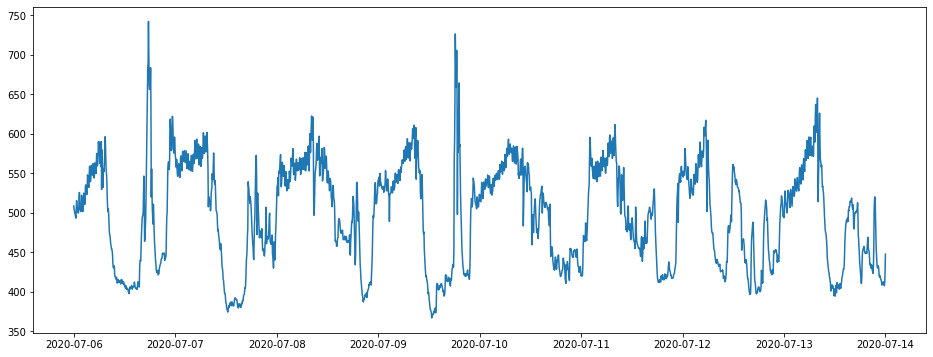

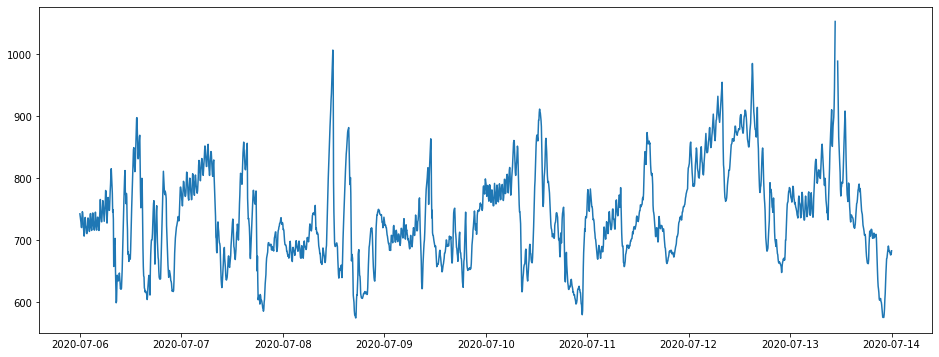

In [13]:
for bb in [25,36]:
    beacon_bb = beacon_data[beacon_data['Beacon'] == bb][datetime(2020,7,6):datetime(2020,7,14)]
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(beacon_bb.index,beacon_bb['CO2'])

## How much data were collected?
Given the study period, we want to know how much of the possible data were collected

### Number of Hours
A nice metric would to be to see how many hours of data were collected. 

The number of hours is calculated as the sum of the hours each sensor on each beacon was operational.

In [14]:
# Getting number of datapoints
n_datapoints = 0
for sensor in ['TVOC','Lux','NO2','CO','CO2','PM_C_2p5']:
    data_per_sensor = beacon_data.loc[:,sensor]
    data_per_sensor.dropna(inplace=True)
    if sensor in ['NO2','CO']:
        t = len(beacon_data.loc[:,f'T_{sensor}'].dropna())
        rh = len(beacon_data.loc[:,f'RH_{sensor}'].dropna())
        print('Comparing DGS sensor readings:')
        print(f'\tT: {t}')
        print(f'\tRH: {rh}')
        print(f'\t{sensor}: {len(data_per_sensor)}')
        n_datapoints += max([t,rh,len(data_per_sensor)])
    else:
        print(f'{sensor}: {len(data_per_sensor)}')
        n_datapoints += len(data_per_sensor)
        
# datapoints are collected every five minutes, so we multiply the number of datapoints by 5 to get the minutes
n_hours = n_datapoints * 5 / 60
print(f'Number of hours of data collected: {n_hours}')
print(f'Number of days of data collected: {n_hours / 24}')

TVOC: 436414
Lux: 377945
Comparing DGS sensor readings:
	T: 261935
	RH: 262704
	NO2: 262505
Comparing DGS sensor readings:
	T: 436985
	RH: 438330
	CO: 442059
CO2: 446234
PM_C_2p5: 447505
Number of hours of data collected: 201071.75
Number of days of data collected: 8377.989583333334


In [15]:
total_sensor_datapoints = total_datapoints / len(sensors) * len(beacon_data['Beiwe'].unique())
total_no2_datapoints = total_datapoints / len(sensors) * 13
for key in sensor_datapoints_dict.keys():
    if key == 'NO2':
        percentage_complete = round(sensor_datapoints_dict[key] / total_no2_datapoints * 100,1)
    else:
        percentage_complete = round(sensor_datapoints_dict[key] / total_sensor_datapoints * 100,1)
    print(f'{key}: {percentage_complete}')

CO2: 72.1
PM_C_2p5: 72.3
Lux: 61.0
NO2: 81.5
CO: 71.4
TVOC: 70.5


## What are typical measurements?

### Histograms
These plots help show typical measurements by the sensors which we can use to refine our raw values

#### Raw Data
Here we summarize the distributions of values for the raw data. This helps us see what values we are measuring.

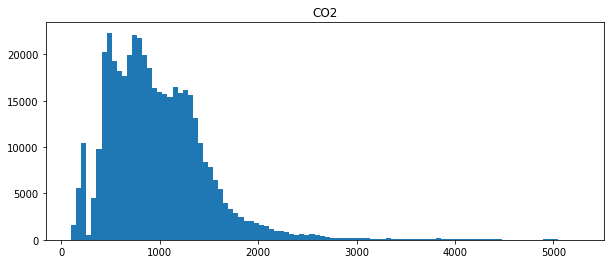

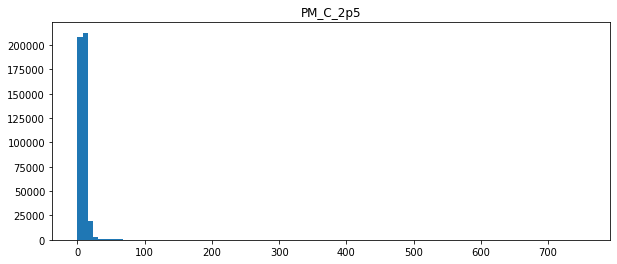

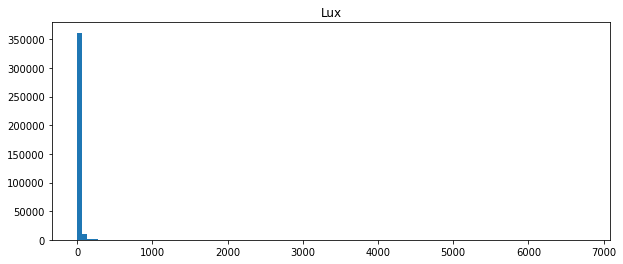

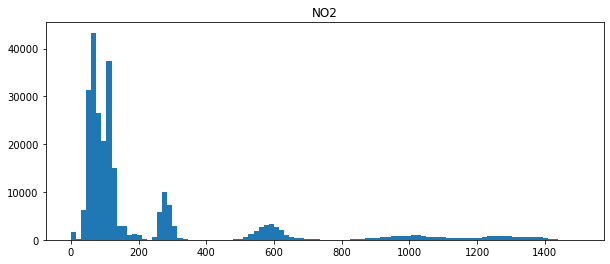

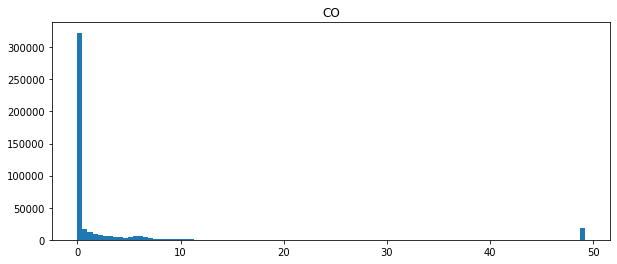

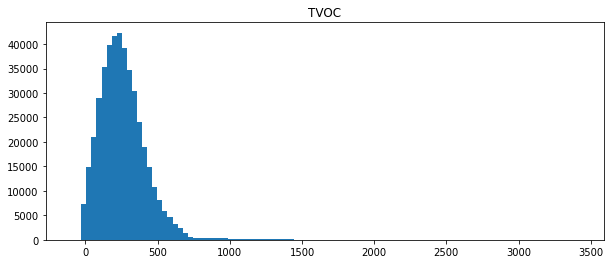

In [16]:
for pollutant in sensors:
    fig, ax = plt.subplots(figsize=(10,4))
    ax.hist(beacon_data[pollutant],bins=100)
    ax.set_title(pollutant)

Perhaps a certain participant has bad values, now we check the distributions of all the beacons still considering the raw values.

CO2


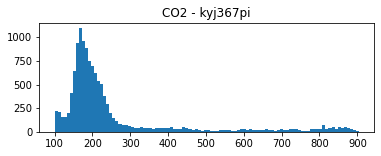

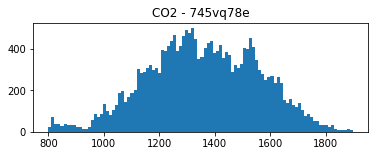

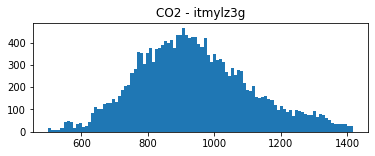

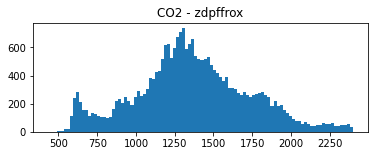

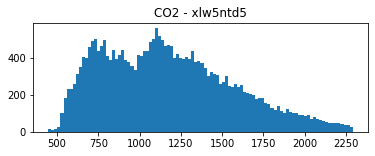

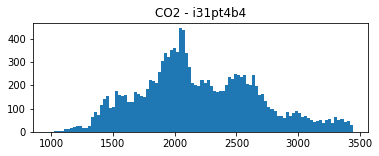

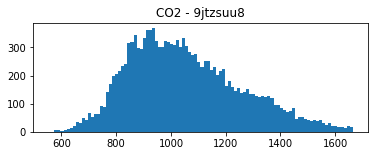

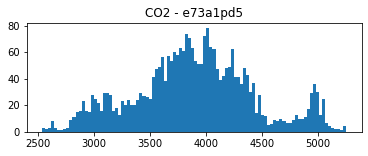

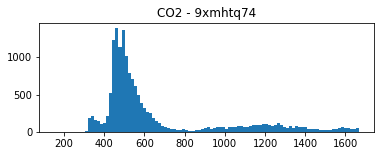

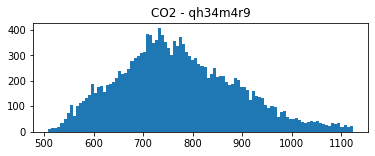

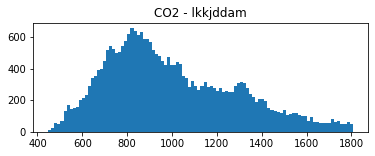

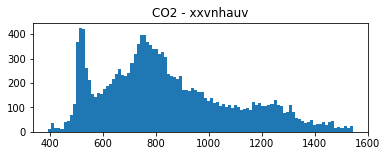

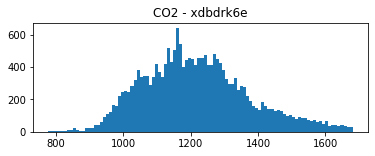

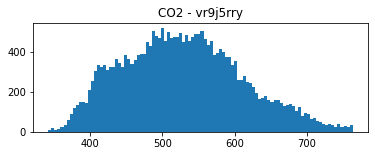

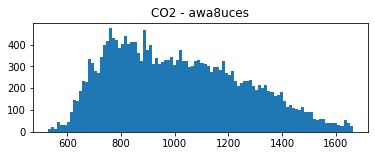

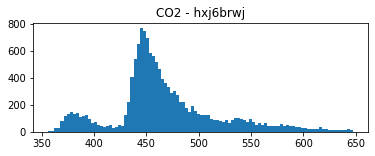

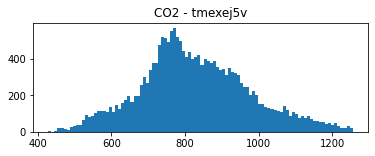

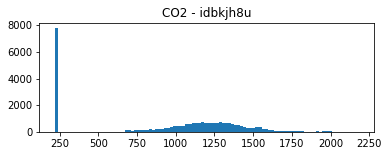

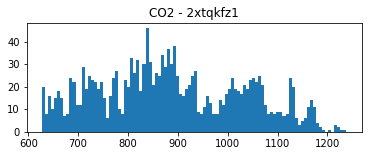

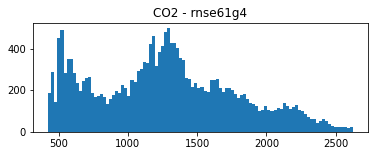

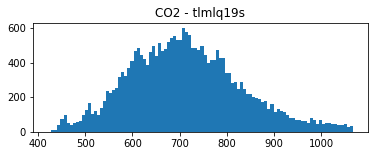

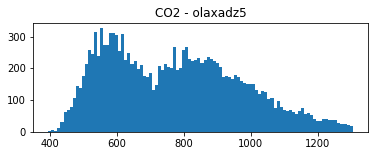

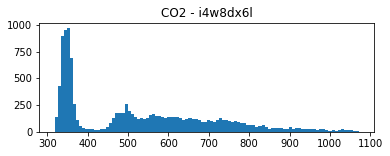

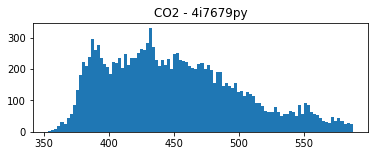

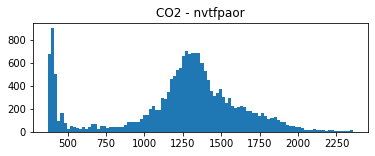

PM_C_2p5


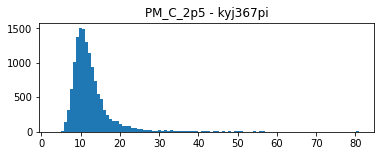

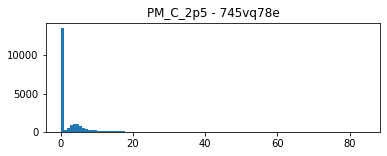

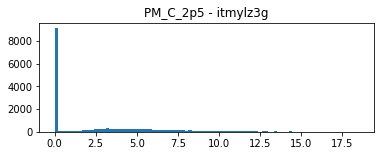

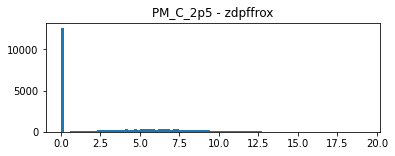

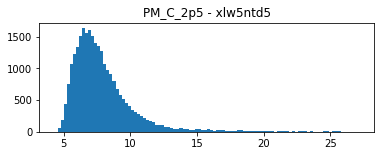

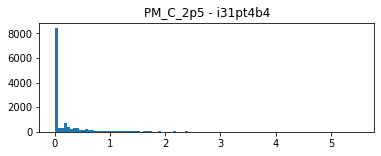

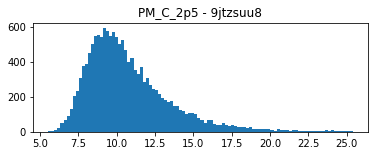

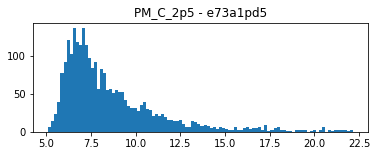

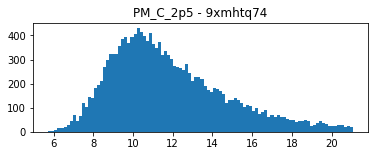

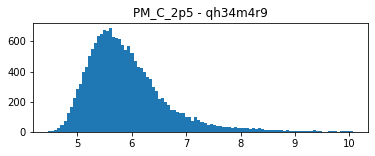

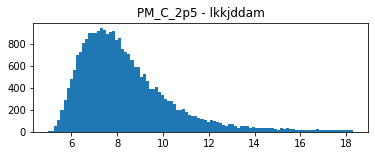

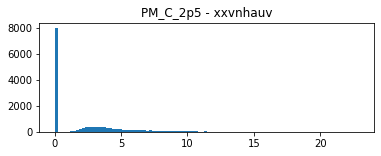

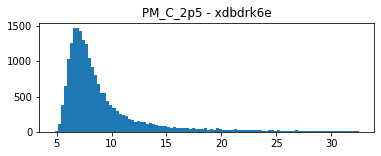

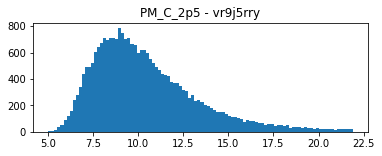

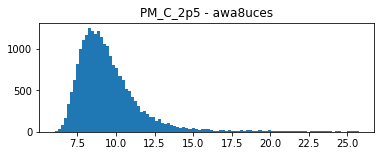

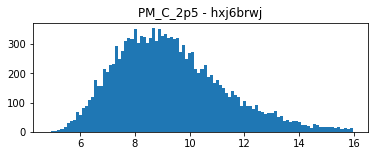

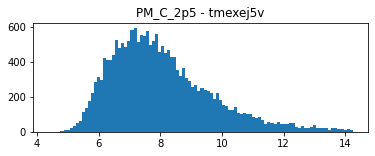

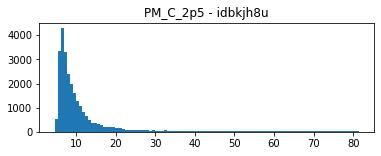

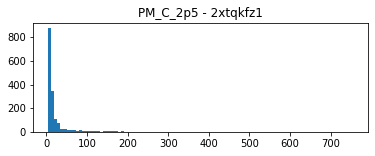

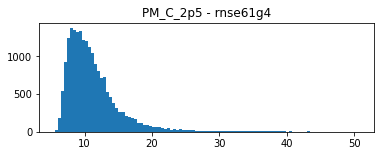

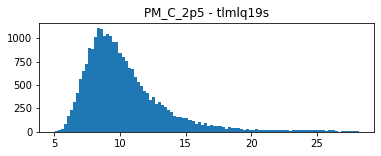

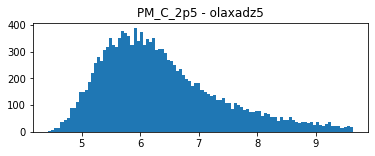

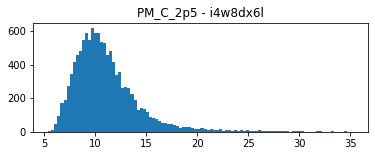

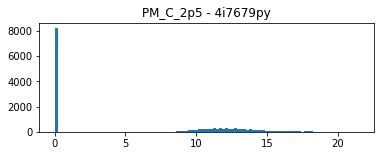

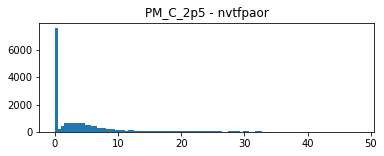

Lux


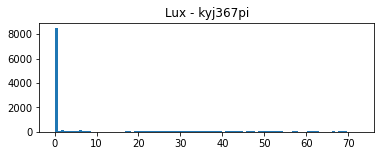

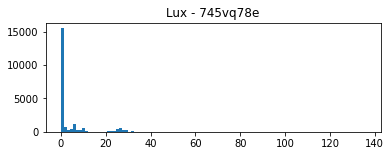

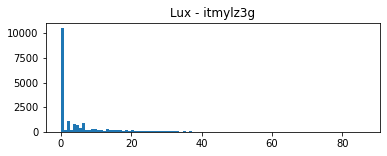

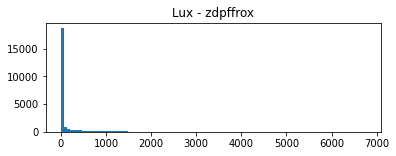

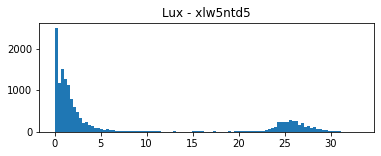

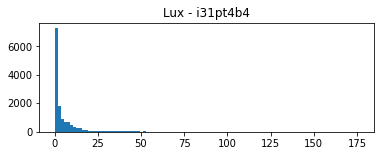

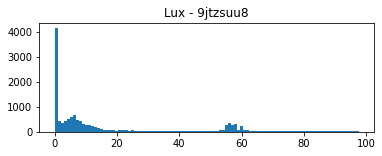

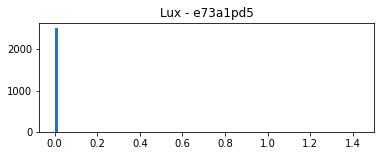

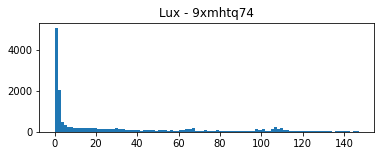

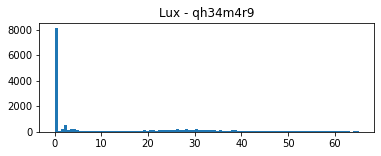

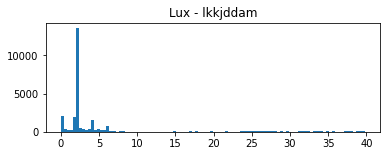

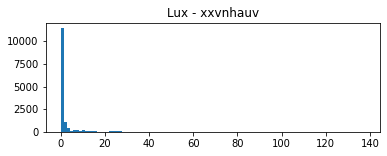

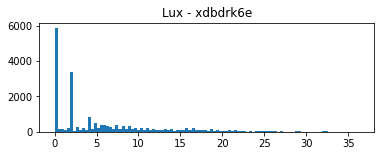

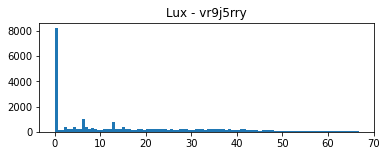

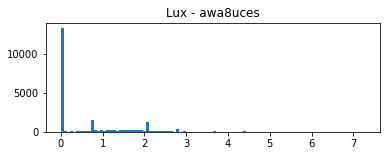

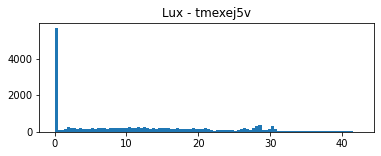

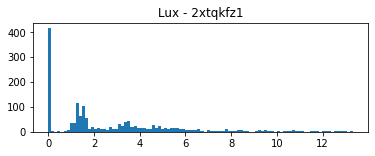

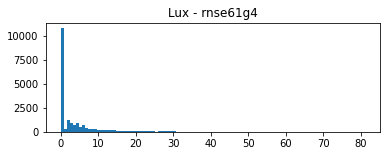

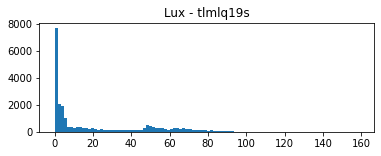

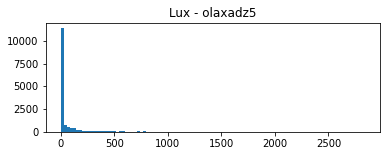

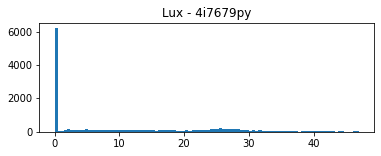

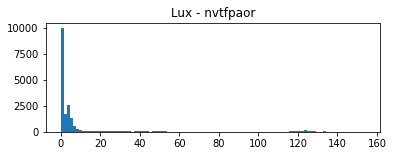

NO2


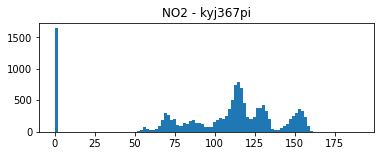

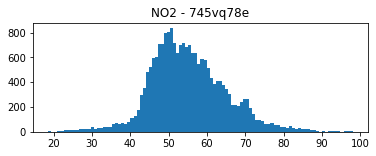

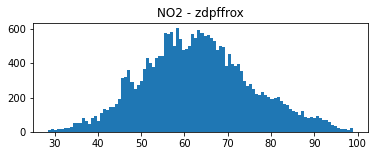

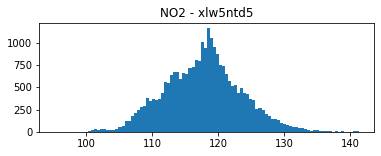

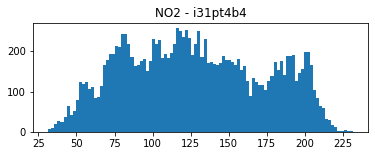

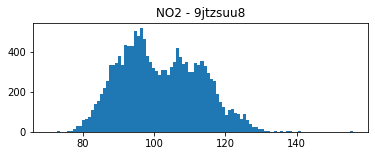

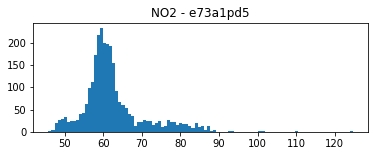

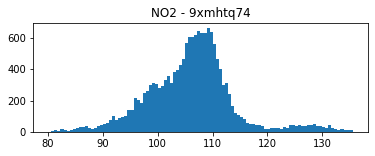

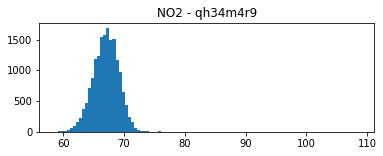

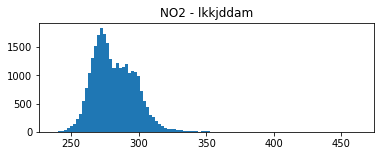

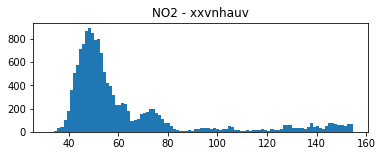

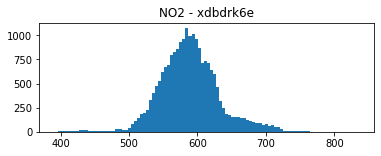

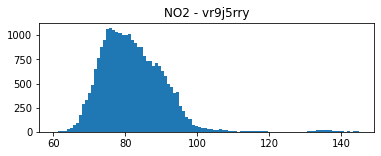

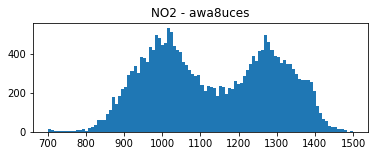

CO


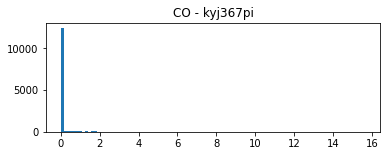

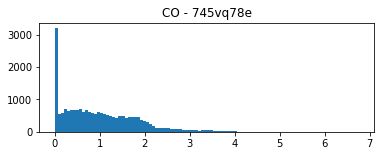

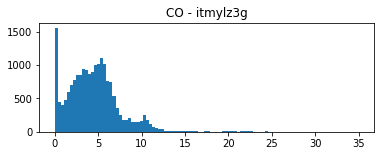

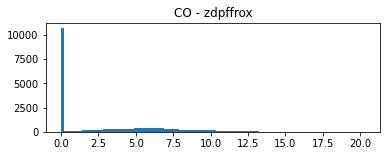

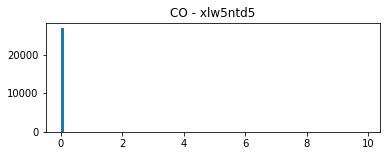

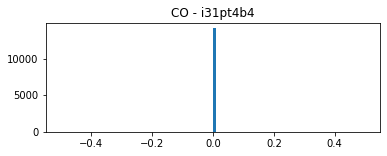

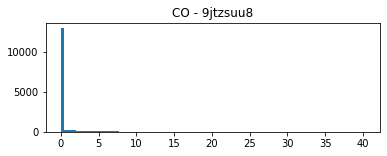

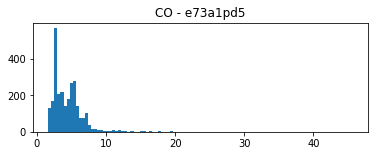

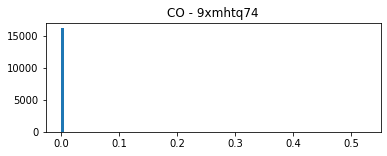

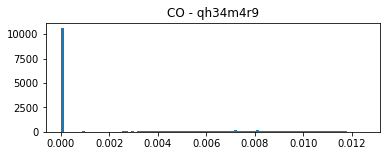

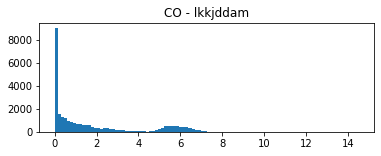

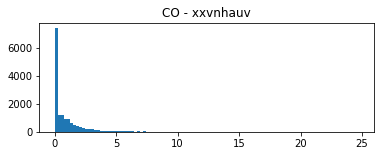

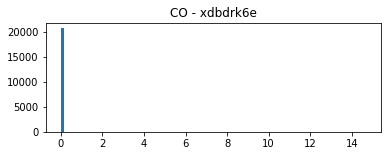

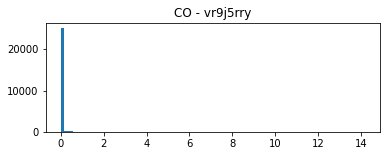

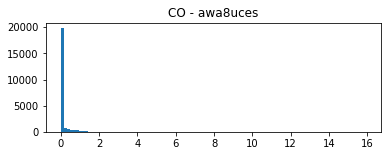

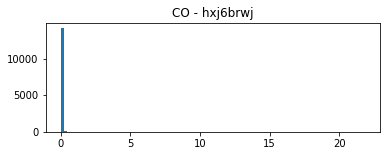

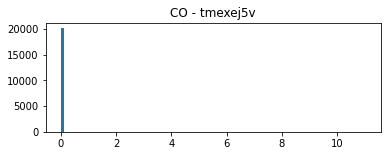

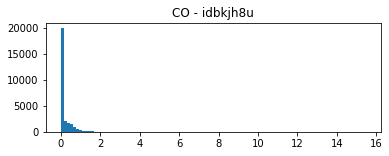

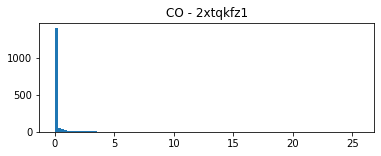

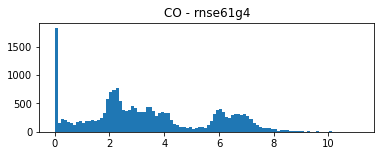

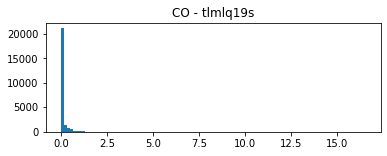

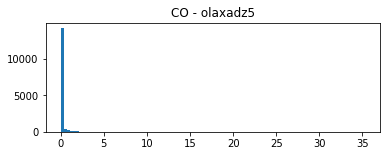

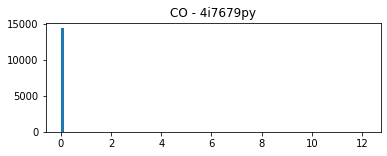

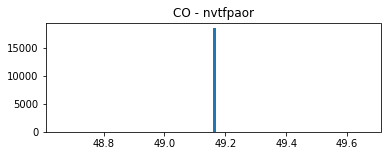

TVOC


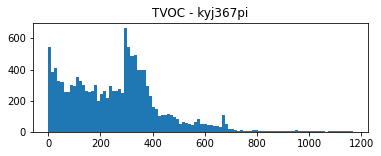

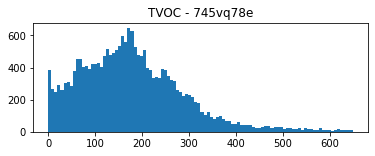

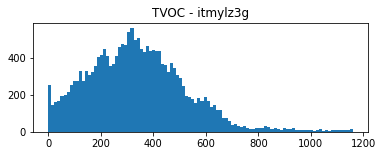

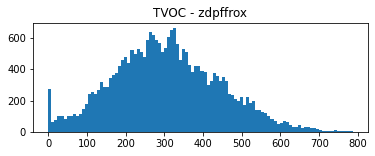

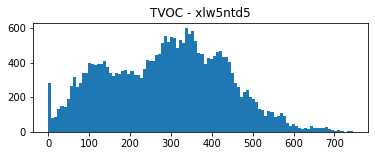

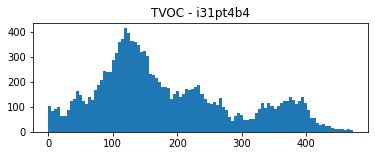

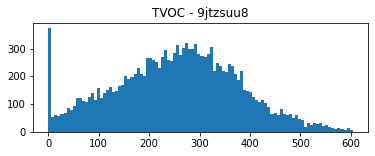

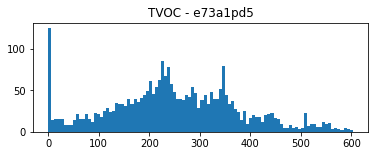

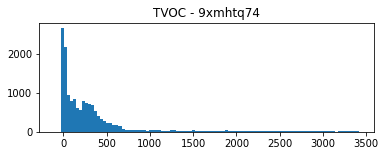

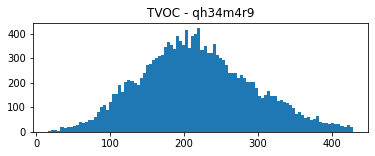

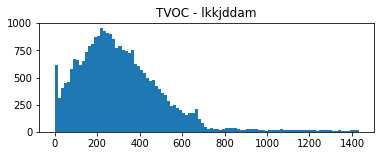

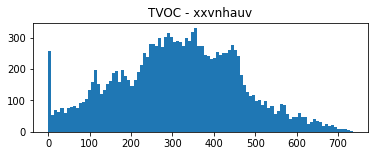

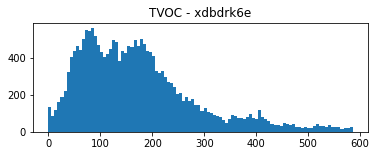

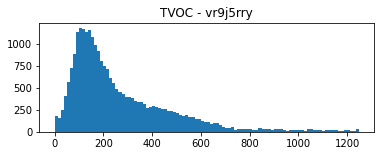

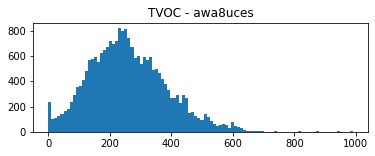

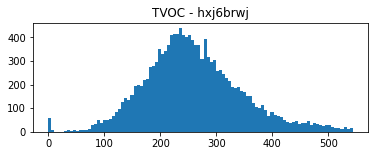

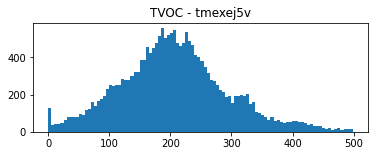

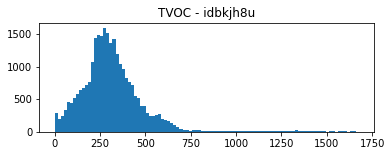

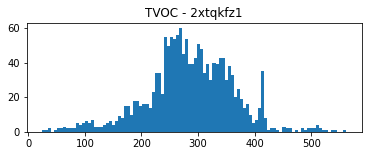

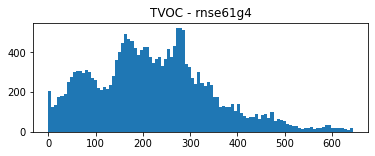

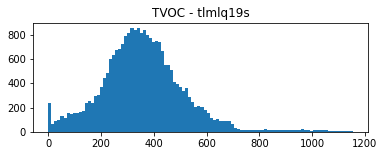

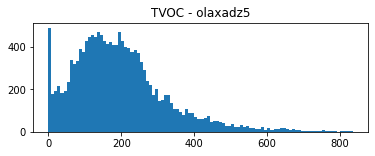

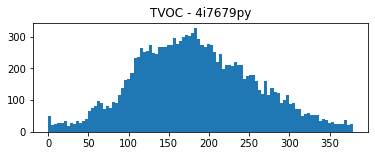

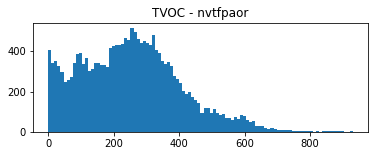

In [17]:
for pollutant in sensors:
    print(pollutant)
    for pt in beacon_data['Beiwe'].unique():
        beacon_pt = beacon_data[beacon_data['Beiwe'] == pt]
        if len(beacon_pt[pollutant].dropna()) > 0:
            fig, ax = plt.subplots(figsize=(6,2))
            ax.hist(beacon_pt[pollutant],bins=100)
            ax.set_title(f'{pollutant} - {pt}')

            plt.show()
            plt.close()

#### Notes
Some thoughts regarding the pre-processing

##### Carbon Dioxide
Shows that pre-processing cannot be done in bulk. Extreme values for one device might not be extreme for another device so each device should be processed separately before combining. 

##### Lux
We need to remove values that are -100 since those correspond to errors.


<div class="alert alert-block alert-success">
    Completed the above notes
</div>

# Example Figures
These figures are meant to give a few examples of the processed data.

In [18]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## CO2
We want to look at CO2 concentrations over a short time interval from a variety of the participants.

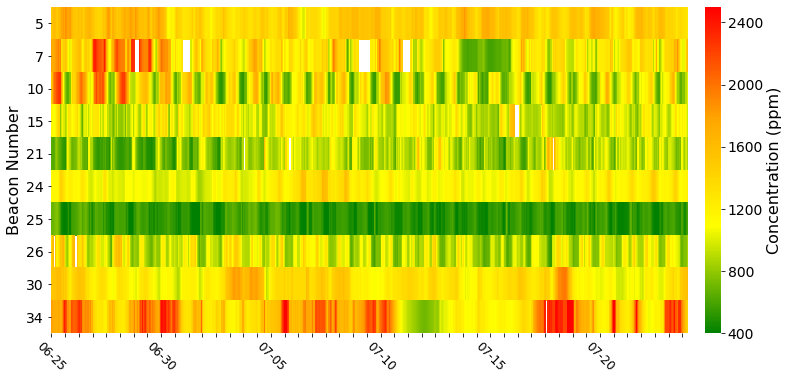

In [19]:
sdate = datetime(2020,6,25)
edate = datetime(2020,7,24)
good_CO2_sensors = [5,7,10,15,21,24,25,26,30,34] # beacon with properly operating CO2 sensors
beacon_CO2 = beacon_data[beacon_data['Beacon'].isin(good_CO2_sensors)]
beacon_CO2 = beacon_CO2[['CO2','Beacon']]
heatmap_df = pd.DataFrame()
for beacon in beacon_CO2['Beacon'].unique():
    df = beacon_CO2[beacon_CO2['Beacon'] == beacon]
    df = df.resample('60T').mean()
    df = df[sdate:edate]
    df.columns = [beacon,'Beacon']
    heatmap_df = heatmap_df.append(df[[beacon]].T)
    
heatmap_df.sort_index(inplace=True)
fig, axes = plt.subplots(1,2,figsize=(12,6),gridspec_kw={'width_ratios': [40, 1]})
sns.heatmap(heatmap_df, vmin=400, vmax=2500, cbar_kws={'ticks':np.arange(400,2800,400),'label':'Concentration (ppm)'}, cmap=create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.33, 0.66, 1]), cbar_ax=axes[1], ax=axes[0])

ax = axes[0]
xlabels = ax.get_xticklabels()
new_xlabels = []
for label in xlabels:
    if label.get_text()[11:13] == "00":
        new_xlabels.append(label.get_text()[5:10])
    else:
        new_xlabels.append('')

ax.set_xticklabels(new_xlabels,rotation=-45)
ax.set_xlabel('')

ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_ylabel('Beacon Number')

#plt.savefig("../reports/UTx000_COVID/beacon-co2-heatmap-reduced.pdf")
plt.subplots_adjust(wspace=0.05)
plt.show()
plt.close()

# Filtered Data Summary
Borrowing from other research, we can create a table of values for each of the variables measured by the beacon.

## Filtered by Fitbit and GPS
These data are those for nights when Fitbit detects sleep and the person is home.

In [20]:
beacon_fitbit = pd.read_csv('../data/processed/bpeace2-beacon-fb_and_gps_restricted.csv',
                             index_col=0)
beacon_fitbit.tail()

,Lat,Long,Alt,Accuracy,TVOC,eCO2,Lux,Visible,Infrared,NO2,...,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time
2020-07-29 06:35:00,30.75694,-94.41760,63.315425,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-28 20:20:00,2020-07-29 07:03:00
2020-07-29 06:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-28 20:20:00,2020-07-29 07:03:00
2020-07-29 06:45:00,30.75708,-94.41779,79.275050,7.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-28 20:20:00,2020-07-29 07:03:00
2020-07-29 06:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-28 20:20:00,2020-07-29 07:03:00
2020-07-29 06:55:00,30.75704,-94.41796,78.810000,65.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17,9xmhtq74,50,59,2020-07-28 20:20:00,2020-07-29 07:03:00


Combining the temperature and relative humidity measurements

In [21]:
beacon_fitbit[beacon_fitbit['Beacon'] == 11]

,Lat,Long,Alt,Accuracy,TVOC,eCO2,Lux,Visible,Infrared,NO2,...,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time
2020-07-14 00:00:00,30.290430,-97.750640,164.902100,32.004830,27.24,571.40,0.000,0.0,0.0,73.72,...,0.256824,0.744120,1.098866,1.129220,11,i31pt4b4,57,77,2020-07-13 23:57:30,2020-07-14 08:21:30
2020-07-14 00:05:00,NaN,NaN,NaN,NaN,32.32,588.60,0.000,0.0,0.0,75.20,...,0.332716,1.019514,1.520585,1.563458,11,i31pt4b4,57,77,2020-07-13 23:57:30,2020-07-14 08:21:30
2020-07-14 00:10:00,30.290360,-97.750620,154.172950,48.502415,33.32,581.68,0.000,0.0,0.0,75.44,...,0.056556,0.059372,0.059372,0.059372,11,i31pt4b4,57,77,2020-07-13 23:57:30,2020-07-14 08:21:30
2020-07-14 00:15:00,NaN,NaN,NaN,NaN,22.20,551.32,0.000,0.0,0.0,73.60,...,0.035347,0.037108,0.037108,0.037108,11,i31pt4b4,57,77,2020-07-13 23:57:30,2020-07-14 08:21:30
2020-07-14 00:20:00,30.290393,-97.750610,154.133190,48.502415,17.84,532.56,0.000,0.0,0.0,74.68,...,0.321039,0.959258,1.424445,1.464248,11,i31pt4b4,57,77,2020-07-13 23:57:30,2020-07-14 08:21:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28 06:50:00,NaN,NaN,NaN,NaN,270.00,1311.20,0.000,0.0,0.0,168.24,...,0.000000,0.000000,0.000000,0.000000,11,i31pt4b4,57,77,2020-08-28 00:01:30,2020-08-28 07:15:30
2020-08-28 06:55:00,NaN,NaN,NaN,NaN,273.88,1324.40,0.408,0.2,0.0,167.76,...,0.000000,0.000000,0.000000,0.000000,11,i31pt4b4,57,77,2020-08-28 00:01:30,2020-08-28 07:15:30
2020-08-28 07:00:00,30.290497,-97.750727,152.655833,64.334943,277.04,1329.92,2.040,1.0,0.0,168.64,...,0.000000,0.000000,0.000000,0.000000,11,i31pt4b4,57,77,2020-08-28 00:01:30,2020-08-28 07:15:30
2020-08-28 07:05:00,NaN,NaN,NaN,NaN,263.80,1289.55,2.040,1.0,0.0,166.85,...,0.000000,0.000000,0.000000,0.000000,11,i31pt4b4,57,77,2020-08-28 00:01:30,2020-08-28 07:15:30


In [22]:
datetime(2020,9,15) - datetime(2015,9,15)

datetime.timedelta(days=1827)

In [23]:
beacon_fitbit['T'] = beacon_fitbit[['T_CO','T_NO2']].mean(axis=1)
beacon_fitbit['RH'] = beacon_fitbit[['RH_CO','RH_NO2']].mean(axis=1)

Removing unecessary columns

In [24]:
variables = ['Lux','T','RH','TVOC','CO2','CO','NO2','PM_C_1','PM_C_2p5','PM_C_10']
beacon_fitbit_important = beacon_fitbit[variables]
beacon_fitbit_important.columns

Index(['Lux', 'T', 'RH', 'TVOC', 'CO2', 'CO', 'NO2', 'PM_C_1', 'PM_C_2p5',
       'PM_C_10'],
      dtype='object')

Getting summary stats

In [25]:
stats = {'n':[],'avg':[],'med':[],'min':[],'25%':[],'75%':[],'max':[],'skewness':[],'kurtosis':[]}
precision = 2
for variable in variables:
    li = beacon_fitbit_important[variable].dropna().values
    stats['n'].append(len(li))
    stats['avg'].append(round(np.nanmean(li),precision))
    stats['med'].append(round(np.nanmedian(li),precision))
    stats['min'].append(round(np.nanmin(li),precision))
    stats['25%'].append(round(np.nanpercentile(li,25),precision))
    stats['75%'].append(round(np.nanpercentile(li,75),precision))
    stats['max'].append(round(np.nanmax(li),precision))
    stats['skewness'].append(round(scipy.stats.skew(li),precision))
    stats['kurtosis'].append(round(scipy.stats.kurtosis(li),precision))

Looking at those stats

In [26]:
stats_df = pd.DataFrame(data=stats)
stats_df.index = variables
stats_df

,n,avg,med,min,25%,75%,max,skewness,kurtosis
Lux,24110,2.96,0.00,0.00,0.00,1.96,4439.11,140.87,21159.15
T,25130,26.68,27.00,18.65,25.00,28.00,31.72,-0.52,0.07
RH,25456,43.12,42.44,30.80,39.50,46.04,62.93,0.58,0.33
TVOC,25100,262.30,237.36,0.00,178.24,322.60,1393.20,1.62,5.77
CO2,24420,1059.11,914.33,100.20,744.06,1248.42,3441.30,1.73,3.71
CO,25490,0.86,0.00,0.00,0.00,0.19,14.56,2.26,4.31
NO2,15768,113.19,77.64,0.00,66.60,113.85,646.48,3.47,12.81
PM_C_1,25429,2.48,2.12,0.00,1.43,3.19,72.87,9.30,156.73
PM_C_2p5,25437,6.34,6.43,0.00,4.63,8.48,82.54,3.07,32.97
PM_C_10,25413,9.84,10.36,0.00,6.70,13.34,89.18,1.32,10.86


Reformating the columns for plotting

In [27]:
beacon_fitbit_important.columns = ['TVOC','Light','NO$_2$','CO','T','RH','CO$_2$','PM$_1$','PM$_{2.5}$','PM$_{10}$']

Correlation matrix between hte "important" variables

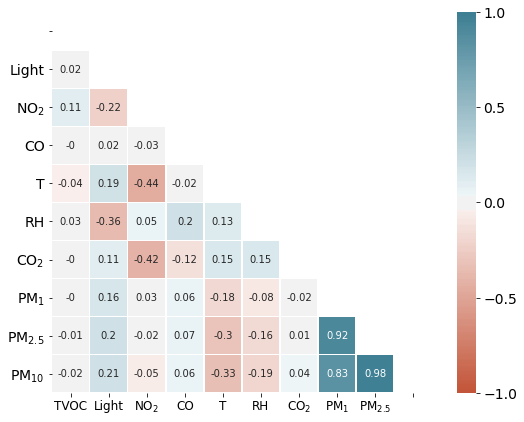

In [28]:
corr = beacon_fitbit_important.corr()
corr = round(corr,2)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, mask=mask, 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                 square=True,linewidths=0.5,annot=True,ax=ax)

yticklabels = ax.get_yticklabels()
yticklabels[0] = ' '
ax.set_yticklabels(yticklabels,rotation=0,ha='right')

xticklabels = ax.get_xticklabels()
xticklabels[-1] = ' '
ax.set_xticklabels(xticklabels,rotation=0,ha='center')

plt.show()
plt.close()

## Filtered by EMA and Fitbit

In [29]:
beacon_filtered = pd.read_csv('../data/processed/bpeace2-beacon-fb_ema_and_gps_restricted.csv',
                             index_col=0)
beacon_filtered.head()

,Lat,Long,Alt,Accuracy,TVOC,eCO2,Lux,Visible,Infrared,NO2,...,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time
2020-08-10 05:10:00,30.58838,-97.42591,113.98145,5.29684,185.50,750.25,2.04,1.0,0.0,288.95,...,1.747382,6.748117,10.714056,11.507244,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,166.08,706.48,2.04,1.0,0.0,277.12,...,1.753108,6.515844,10.288899,11.043510,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,151.40,666.48,2.04,1.0,0.0,277.44,...,1.696069,6.215933,9.795078,10.510907,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,158.84,686.92,2.04,1.0,0.0,282.44,...,1.609633,6.486098,10.357869,11.132223,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,146.15,669.20,2.04,1.0,0.0,272.80,...,1.660413,6.721101,10.739605,11.543306,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30


Checking to see what the minimum CO2 value over 400 ppm is (for cleaning purposes in the ```make_dataset.py``` source code).

In [30]:
np.nanmin(beacon_filtered[beacon_filtered['CO2'] > 400]['CO2'])

400.2021462517737

Combining T and RH columns from CO and NO2 sensors - averaging where both measured a value and using the single value if only one measured T or RH.

In [31]:
beacon_filtered['T'] = beacon_filtered[['T_CO','T_NO2']].mean(axis=1)
beacon_filtered['RH'] = beacon_filtered[['RH_CO','RH_NO2']].mean(axis=1)

Dropping all unecessary columns

In [32]:
variables = ['Lux','T','RH','TVOC','CO2','CO','NO2','PM_C_1','PM_C_2p5','PM_C_10']
beacon_important = beacon_filtered[variables]
beacon_important.columns

Index(['Lux', 'T', 'RH', 'TVOC', 'CO2', 'CO', 'NO2', 'PM_C_1', 'PM_C_2p5',
       'PM_C_10'],
      dtype='object')

Getting descriptive stats

In [33]:
stats = {'n':[],'avg':[],'med':[],'min':[],'25%':[],'75%':[],'max':[],'skewness':[],'kurtosis':[]}
precision = 2
for variable in variables:
    li = beacon_filtered[variable].dropna().values
    stats['n'].append(len(li))
    stats['avg'].append(round(np.nanmean(li),precision))
    stats['med'].append(round(np.nanmedian(li),precision))
    stats['min'].append(round(np.nanmin(li),precision))
    stats['25%'].append(round(np.nanpercentile(li,25),precision))
    stats['75%'].append(round(np.nanpercentile(li,75),precision))
    stats['max'].append(round(np.nanmax(li),precision))
    stats['skewness'].append(round(scipy.stats.skew(li),precision))
    stats['kurtosis'].append(round(scipy.stats.kurtosis(li),precision))

Creating a stats dataframe and outputting the results

In [34]:
stats_df = pd.DataFrame(data=stats)
stats_df.index = variables
stats_df

,n,avg,med,min,25%,75%,max,skewness,kurtosis
Lux,13365,2.52,0.00,0.00,0.00,1.47,74.91,4.34,23.68
T,14019,26.71,27.00,18.65,25.00,28.00,31.72,-0.37,-0.20
RH,14229,43.03,42.24,30.80,39.50,46.00,62.93,0.58,0.47
TVOC,14077,266.34,239.64,0.00,178.40,335.56,1393.20,1.66,6.24
CO2,13713,1022.11,907.03,100.20,754.21,1212.74,3436.35,1.90,5.77
CO,14239,0.81,0.00,0.00,0.00,0.20,14.56,2.38,5.10
NO2,8814,113.97,78.68,0.00,66.68,113.32,646.48,3.60,13.41
PM_C_1,14235,2.44,2.27,0.00,1.52,3.25,22.26,2.85,17.64
PM_C_2p5,14232,6.44,6.65,0.00,5.13,8.58,37.02,0.77,4.28
PM_C_10,14227,10.12,10.65,0.00,8.41,13.53,51.59,0.29,2.01


Formatting the dataframe nicely

In [35]:
beacon_important.columns = ['TVOC','Light','NO$_2$','CO','T','RH','CO$_2$','PM$_1$','PM$_{2.5}$','PM$_{10}$']

Creating a correlation matrix

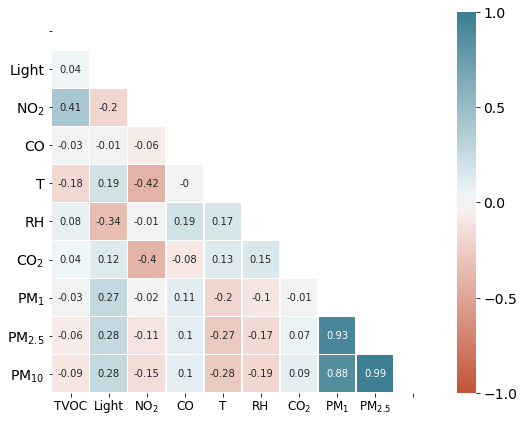

In [36]:
corr = beacon_important.corr()
corr = round(corr,2)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, mask=mask, 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                 square=True,linewidths=0.5,annot=True,ax=ax)

yticklabels = ax.get_yticklabels()
yticklabels[0] = ' '
ax.set_yticklabels(yticklabels,rotation=0,ha='right')

xticklabels = ax.get_xticklabels()
xticklabels[-1] = ' '
ax.set_xticklabels(xticklabels,rotation=0,ha='center')

plt.savefig('../reports/AHSRAE_summer20/correlation_matrix.pdf')
plt.show()
plt.close()

# Filtered Data Completeness
We can also look at how complete the datasets are. There are two ways to summarize the completeness:
1. Percent of possible data collected over the study period i.e. while the participants had their respective devices
2. Percent of possible data collected while the beacon was actually operating. 
3. Percent of possible data collected when participants are home and asleep.
4. Percent of possible data collected when participants are home, asleep, and answered the survey the following morning. 


In [37]:
overall_op = {}
type(overall_op)

dict

## Percent of Possible Data During Study Period
We first need to ensure that we have the correct start and stop periods for each individual. This information is housed in the ```details``` dataframe. 

We want to cross-reference the arrival date of the beacon to the individual and assume that is the start date. The end date can be changed to correspond to Sept. 1st or the return date - whatever happened first.  

In [67]:
print(len(beacon_df['Beacon'].unique()))

25


### Number of Possible Nights
Another, related metric, is how many nights out of the possible we recorded data for each individual. We can use the same loop to determine the maximum number of nights.

In [68]:
variables = ['Beacon','Lux','TVOC','CO2','CO','NO2','PM_C_1','PM_C_2p5','PM_C_10']
beacon_df = beacon_data[variables].sort_index()[:datetime(2020,9,1)]

max_n = 0
max_n_no2 = 0
no2_beacons = []
n_nights_max = 0
for bb in beacon_df['Beacon'].unique():
    if bb not in [22,26,46]: # beacons with no Fitbit data or GPS data
        beacon_pt = beacon_df[beacon_df['Beacon'] == bb]
        starting_date = pd.to_datetime(details[details['Beacon'] == bb]['start_date'].values[0])
        ending_date = pd.to_datetime(details[details['Beacon'] == bb]['end_date'].values[0])
        if ending_date > datetime(2020,9,1):
            ending_date = datetime(2020,9,1)

        max_n += (ending_date - starting_date).total_seconds()/60/5
        n_nights_max += (ending_date.date() - starting_date.date()).days
        # Add no2 count
        if details[details['Beacon'] == bb]['NO2'].values[0] == 'Yes':
            max_n_no2 += (ending_date - starting_date).total_seconds()/60/5
            no2_beacons.append(bb)
        else:
            print(f'{bb}: no NO2 data')
        
print(f'Number of Beacons with NO2 Sensors: {len(no2_beacons)}')

28: no NO2 data
30: no NO2 data
29: no NO2 data
34: no NO2 data
32: no NO2 data
38: no NO2 data
40: no NO2 data
44: no NO2 data
36: no NO2 data
Number of Beacons with NO2 Sensors: 13


Now that we have the max number of data points possible, we can divide the number of actual measurments by the count. We have to take special consideration for the NO2 sensor though since not all devices had one. 

In [69]:
op_period_df = pd.DataFrame()
op_period_df['n'] = beacon_df.count()
op_period_df['max_n'] = max_n
op_period_df['percent'] = beacon_df.count()/max_n
op_period_df.loc['NO2','max_n'] = max_n_no2
op_period_df.loc['NO2','percent'] = op_period_df.loc['NO2','n'] / max_n_no2
op_period_df.drop('Beacon',inplace=True)
op_period_df

,n,max_n,percent
Lux,362771,471369.4,0.769611
TVOC,414669,471369.4,0.879711
CO2,424718,471369.4,0.901030
CO,419922,471369.4,0.890855
NO2,248476,297914.4,0.834052
PM_C_1,427021,471369.4,0.905916
PM_C_2p5,426367,471369.4,0.904528
PM_C_10,425889,471369.4,0.903514


In [70]:
total_n = op_period_df['n'].sum()
total_max_n = op_period_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.8755615913516835


Adding to overall operation

In [71]:
overall_op['During Study'] = list(np.around(op_period_df['percent'].values*100,1))
overall_op['During Study'].append(round(total_n/total_max_n*100,1))

Also with the max number of nights, we can look at the unique ending times of a person's sleep schedule to to get an idea of how many nights we did record.

In [72]:
print(f'Number of Possible Nights: {n_nights_max}')

Number of Possible Nights: 1648


## Percent of Possible Data while Operating
Now we look at when the beacon is powered on and see how much data was gathered

In [43]:
temp = beacon_df.drop(['Beacon'],axis=1).dropna(how='all')
op_df = pd.DataFrame()
op_df['n'] = temp.count()
op_df['max_n'] = len(temp)
op_df['percent'] = temp.count()/len(temp)

Have to change up the approach for the NO2 sensor and only consider beacons with the sensor for ```max_n```

In [44]:
# dataframe with only beacons with NO2 sensors and removing times when all sensors measured nothing
no2_temp = beacon_df[beacon_df['Beacon'].isin(no2_beacons)].drop(['Beacon'],axis=1).dropna(how='all')
op_df.loc['NO2','max_n'] = len(no2_temp)
op_df.loc['NO2','percent'] = op_df.loc['NO2','n'] / len(no2_temp)
op_df


,n,max_n,percent
Lux,362771,433163,0.837493
TVOC,414669,433163,0.957305
CO2,424718,433163,0.980504
CO,419922,433163,0.969432
NO2,248476,270307,0.919236
PM_C_1,427021,433163,0.985821
PM_C_2p5,426367,433163,0.984311
PM_C_10,425889,433163,0.983207


In [45]:
total_n = op_df['n'].sum()
total_max_n = op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9537873117154305


Adding to overall op

In [46]:
overall_op['While Operating'] = list(np.around(op_df['percent'].values*100,1))
overall_op['While Operating'].append(round(total_n/total_max_n*100,1))

The number of nights recorded will be the same reported above:

In [47]:
print(f'Number of Possible Nights: {n_nights_max}')

Number of Possible Nights: 1892


## Percent of Possible Data while Asleep and At Homes
Now we look at an even smaller window of the nightly measured values - filtered by GPS and Fitbit

In [66]:
beacon_fitbit_important = beacon_fitbit[variables]
temp = beacon_fitbit_important.drop(['Beacon'],axis=1).dropna(how='all')
night_op_df = pd.DataFrame()
night_op_df['n'] = temp.count()
night_op_df['max_n'] = len(temp)
night_op_df['percent'] = temp.count()/len(temp)

17


Considering NO2 only now

In [49]:
no2_temp = beacon_fitbit_important[beacon_fitbit_important['Beacon'].isin(no2_beacons)].dropna(how='all')
print('Number of Beacons:', len(no2_temp['Beacon'].unique()))
no2_temp.drop(['Beacon'],axis=1,inplace=True)
night_op_df.loc['NO2','max_n'] = len(no2_temp)
night_op_df.loc['NO2','percent'] = night_op_df.loc['NO2','n'] / len(no2_temp)
night_op_df

Number of Beacons: 12


,n,max_n,percent
Lux,24110,25511,0.945083
TVOC,25100,25511,0.983889
CO2,24420,25511,0.957234
CO,25490,25511,0.999177
NO2,15768,22632,0.696713
PM_C_1,25429,25511,0.996786
PM_C_2p5,25437,25511,0.997099
PM_C_10,25413,25511,0.996159


In [50]:
total_n = night_op_df['n'].sum()
total_max_n = night_op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9500916956994966


Adding to overall operation

In [51]:
overall_op['Asleep and Home'] = list(np.around(night_op_df['percent'].values*100,1))
overall_op['Asleep and Home'].append(round(total_n/total_max_n*100,1))

### Number of nights recorded under this scheme
We look at overall in addition to per sensor.

Overall

In [52]:
df = beacon_fitbit.groupby(['start_time']).mean()
df = df[variables]
df.drop('Beacon',axis=1,inplace=True)
print('Number of Nights Measured:',len(df.dropna(how='all')))

Number of Nights Measured: 318


Per sensor

In [53]:
vars_to_check = ['Lux','TVOC','CO2','CO','NO2','PM_C_1','PM_C_2p5','PM_C_10']
s = 0
for variable in vars_to_check:
    sensor_df = beacon_fitbit[[variable,'start_time','Beacon']]
    sensor_df.dropna(inplace=True)
    print(f'Number of Nights for {variable}:',len(sensor_df['start_time'].unique()))
    print(f'Number of Beacons:', len(sensor_df['Beacon'].unique()))
    s += len(sensor_df['start_time'].unique())
    
print('Total:', s/len(vars_to_check))

Number of Nights for Lux: 315
Number of Beacons: 16
Number of Nights for TVOC: 316
Number of Beacons: 17
Number of Nights for CO2: 318
Number of Beacons: 17
Number of Nights for CO: 318
Number of Beacons: 17
Number of Nights for NO2: 194
Number of Beacons: 11
Number of Nights for PM_C_1: 318
Number of Beacons: 17
Number of Nights for PM_C_2p5: 318
Number of Beacons: 17
Number of Nights for PM_C_10: 318
Number of Beacons: 17
Total: 301.875


Visual inspection to see if it makes sense operation

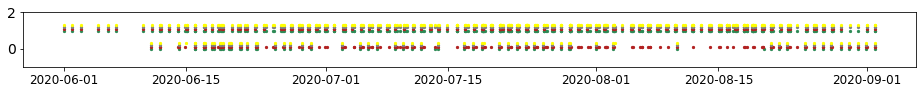

In [54]:
fig, ax = plt.subplots(figsize=(16,1))
colors = ['seagreen','firebrick','grey','yellow']
jitter = 0
for variable, c in zip(['TVOC','NO2','PM_C_2p5','Lux'],colors):
    temp = df[df[variable] > -1000]
    temp['values'] = np.ones(len(temp))
    temp.index = pd.to_datetime(temp.index)
    bad = df[np.isnan(df[variable])]
    bad['values'] = np.zeros(len(bad))
    bad.index = pd.to_datetime(bad.index)
    ax.scatter(temp.index,temp['values']+jitter,color=c,s=5)
    ax.scatter(bad.index,bad['values']+jitter,color=c,s=5)
    jitter += 0.1

ax.set_ylim([-1,2])
plt.show()
plt.close()

## Percent of Possible Data while Asleep, At Home, and Completed Survey
Now we look at the smallest window of the nightly measured values.

In [55]:
beacon_filtered_important = beacon_filtered[variables]
temp = beacon_filtered_important.drop(['Beacon'],axis=1).dropna(how='all')
night_op_df = pd.DataFrame()
night_op_df['n'] = temp.count()
night_op_df['max_n'] = len(temp)
night_op_df['percent'] = temp.count()/len(temp)

Again, considering NO2

In [56]:
no2_temp = beacon_filtered_important[beacon_filtered_important['Beacon'].isin(no2_beacons)].drop(['Beacon'],axis=1).dropna(how='all')
night_op_df.loc['NO2','max_n'] = len(no2_temp)
night_op_df.loc['NO2','percent'] = night_op_df.loc['NO2','n'] / len(no2_temp)
night_op_df

,n,max_n,percent
Lux,13365,14252,0.937763
TVOC,14077,14252,0.987721
CO2,13713,14252,0.962181
CO,14239,14252,0.999088
NO2,8814,10228,0.861752
PM_C_1,14235,14252,0.998807
PM_C_2p5,14232,14252,0.998597
PM_C_10,14227,14252,0.998246


In [57]:
total_n = night_op_df['n'].sum()
total_max_n = night_op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9719070477852935


Adding to overall operation

In [58]:
overall_op['Asleep, Home, and EMA'] = list(np.around(night_op_df['percent'].values*100,1))
overall_op['Asleep, Home, and EMA'].append(round(total_n/total_max_n*100,1))

Checking number of nights

In [59]:
nights_df = beacon_filtered[['start_time']]
n_nights = len(nights_df['start_time'].unique())
print(f'Number of Nights Measured: {n_nights}')

Number of Nights Measured: 207


## Combining Percentages
Putting them all together.

In [60]:
indices = ['Lux',
 'TVOC',
 'CO2',
 'CO',
 'NO2',
 'PM_C_1',
 'PM_C_2p5',
 'PM_C_10',
 'Total']
pd.DataFrame(overall_op, index=indices)

,During Study,While Operating,Asleep and Home,"Asleep, Home, and EMA"
Lux,67.0,83.7,94.5,93.8
TVOC,76.6,95.7,98.4,98.8
CO2,78.5,98.1,95.7,96.2
CO,77.6,96.9,99.9,99.9
NO2,71.6,91.9,69.7,86.2
PM_C_1,78.9,98.6,99.7,99.9
PM_C_2p5,78.8,98.4,99.7,99.9
PM_C_10,78.7,98.3,99.6,99.8
Total,76.2,95.4,95.0,97.2


# Miscellaneous

## Converting NO2
The literature is split on the units they use to report NO2 concentrations.

In [61]:
def convert_no2_to_ppb(concentration):
    '''
    Converts a ug/m3 NO2 concentration to ppb
    '''
    
    MM = 46 #g/mol
    MV = 24.5 #L/mol
    
    return concentration*MV/MM

In [62]:
def convert_no2_to_ugm3(concentration):
    '''
    Converts a ppb NO2 concentration to ug/m3
    '''
    
    MM = 46 #g/mol
    MV = 24.5 #L/mol
    
    return concentration*MM/MV

In [63]:
convert_no2_to_ppb(16.2)

8.628260869565217

In [64]:
convert_no2_to_ugm3(13.8)

25.910204081632656